# Background

Walmart is a renowned retail corporation that operates a chain of hypermarkets. Here, Walmart has provided a data combining of 45 stores including store information and monthly sales. The data is provided on weekly basis. Walmart tries to find the impact of holidays on the sales of store. For which it has included four holidays’ weeks into the dataset which are Christmas, Thanksgiving, Super bowl, Labor Day. Here we are owing to Analyze the dataset given. Before doing that, let me point out the objective of this analysis. 

# Business Objectives

Our Main Objective is to predict sales of store in a week. As in dataset size and time related data are given as feature, so analyze if sales are impacted by time-based factors and space- based factor. Most importantly how inclusion of holidays in a week soars the sales in store? 

# Importing Necessary Libraries and Data

In [1]:
import numpy as np      # To use np.arrays
import pandas as pd     # To use dataframes
from pandas.plotting import autocorrelation_plot as auto_corr

# To plot
import matplotlib.pyplot as plt  
%matplotlib inline    
import matplotlib as mpl
import seaborn as sns

#For date-time
import math
from datetime import datetime
from datetime import timedelta

# Another imports if needs
import itertools
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf

from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose as season
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.linear_model import LinearRegression 
from sklearn import preprocessing

from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima_model import ARIMA
!pip install pmdarima
from pmdarima.utils import decomposed_plot
from pmdarima.arima import decompose
from pmdarima import auto_arima


import warnings
warnings.filterwarnings("ignore")



In [2]:
pd.options.display.max_columns=100 # to see columns 

In [3]:
df_store = pd.read_csv('WSF/stores.csv') #store data
print(f"Row count: {len(df_store)}")

Row count: 45


In [4]:
df_train = pd.read_csv('WSF/train.csv') # train set
print(f"Row count: {len(df_train)}")

Row count: 421570


In [5]:
df_features = pd.read_csv('WSF/features.csv') #external information
print(f"Row count: {len(df_features)}")

Row count: 8190


# First Look to Data and Merging Three Dataframes

In [6]:
df_store.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [7]:
df_train.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [8]:
df_features.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


In [9]:
# merging 3 different sets
df = df_train.merge(df_features, on=['Store', 'Date'], how='inner').merge(df_store, on=['Store'], how='inner')
df.head(5)

,Store,Dept,Date,Weekly_Sales,IsHoliday_x,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday_y,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
1,1,1,2010-02-12,46039.49,True,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True,A,151315
2,1,1,2010-02-19,41595.55,False,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False,A,151315
3,1,1,2010-02-26,19403.54,False,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False,A,151315
4,1,1,2010-03-05,21827.90,False,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False,A,151315


In [10]:
df.drop(['IsHoliday_y'], axis=1,inplace=True) # removing dublicated column

In [11]:
df.rename(columns={'IsHoliday_x':'IsHoliday'},inplace=True) # rename the column

In [12]:
df.head() # last ready data set

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
1,1,1,2010-02-12,46039.49,True,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,A,151315
2,1,1,2010-02-19,41595.55,False,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,A,151315
3,1,1,2010-02-26,19403.54,False,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,A,151315
4,1,1,2010-03-05,21827.90,False,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,A,151315


In [13]:
df.shape

(421570, 16)

# Store & Department Numbers

In [14]:
df['Store'].nunique() # number of different values

45

In [15]:
df['Dept'].nunique() # number of different values

81

Now, I will look at the average weekly sales for each store and each department to see if there is any weird values or not. There are 45 stores and 81 departments for stores. 

In [16]:
store_dept_table = pd.pivot_table(df, index='Store', columns='Dept',
                                  values='Weekly_Sales', aggfunc=np.mean)
display(store_dept_table)

Dept,1,2,3,4,5,6,7,8,9,10,11,12,13,14,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,54,55,56,58,59,60,65,67,71,72,74,77,78,79,80,81,82,83,85,87,90,91,92,93,94,95,96,97,98,99
Store,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,22513.322937,46102.090420,13150.478042,36964.154476,24257.941119,4801.780140,24566.487413,35718.257622,28062.052238,31033.386364,24919.270629,10566.545315,38692.880490,15268.550909,24151.061329,9196.557902,7765.304425,1259.018531,4091.571538,7808.450559,8052.076154,21623.184685,6187.389720,10152.336783,6767.997273,1374.649650,593.113986,4651.040210,3415.295035,2408.533287,8202.668392,5946.431189,11530.831678,2535.730909,1476.203566,2800.495105,79978.222587,NaN,58510.409161,1064.769650,7940.326224,NaN,4872.724406,23.995070,19662.989860,-116.454545,917.727920,11437.931259,NaN,32.712727,2355.439371,90.921053,12817.843357,4000.480629,3372.474476,857.775105,1020.995804,NaN,7436.017343,2732.473357,47390.644895,11652.827413,677.000000,11.500000,33974.792937,17139.314615,29780.696573,20727.860909,5704.048951,3685.875524,46006.277203,82427.547832,64238.943427,135458.969510,71699.182378,63180.568182,120772.062168,33251.831639,35207.348811,11827.770769,306.091081
2,30777.980769,65912.922517,17476.563357,45607.666573,30555.315315,6808.382517,40477.837063,58707.369441,34375.864476,38845.854476,23382.686154,7735.946294,46117.959231,21314.132937,27005.179650,13790.854196,11687.563009,4053.439930,5748.619441,9910.939860,12923.013846,29170.616573,8309.564545,15299.508392,9347.725105,1837.954615,798.913217,7111.482657,4981.155385,3884.756993,11755.096713,7488.096993,17595.203497,3875.588601,2631.750559,4500.250769,85114.996014,2.340000,78174.560210,2592.220769,8768.857692,NaN,7245.541189,29.139848,29675.324545,18.068182,1358.347914,15568.465664,NaN,16.226667,4148.373566,104.502868,13060.297692,5545.122308,21610.019091,1391.520559,221.545946,NaN,12125.255594,4634.609371,72929.496643,16986.406014,817.500000,11.764000,32759.096993,26041.273566,31000.484266,24647.232587,5710.719650,3672.042797,24932.985804,97611.537133,80610.380350,164840.230979,70581.977063,70018.672517,143588.751888,34319.063846,40697.204056,14035.400839,475.896905
3,7328.621049,16841.775664,5509.300769,8434.186503,11695.366573,2012.411818,10044.341608,8310.254196,9062.007692,10871.944126,8774.928042,2383.603007,11363.061678,4626.649021,7871.568322,2634.199650,2960.677739,731.313147,1682.199231,1244.529650,3101.769860,10913.330070,2763.627343,4260.447972,2850.050839,500.193636,166.870070,1517.404056,1243.926993,878.475455,4296.111049,3228.155105,4579.719161,1439.325524,622.689371,NaN,108598.364126,NaN,18203.108252,646.832028,4422.944406,NaN,2133.657762,9.922500,6179.259510,38.875000,NaN,17.581481,NaN,5.411803,961.390210,58.311239,7153.737902,1606.808881,NaN,244.878455,138.125874,NaN,2021.482657,1101.610000,22796.856573,3374.960769,424.000000,6.000000,7230.372448,24.420476,1429.300070,6746.578392,19.330000,874.128182,939.435455,1540.049161,318.685594,7568.280210,NaN,656.294444,15745.528252,3934.540000,343.437357,30.570833,NaN
4,36979.940070,93639.315385,19012.491678,56603.400140,45668.406783,8241.777692,50728.151399,62949.723776,34437.170979,37269.667413,27145.836643,8141.910979,69596.447343,28567.509441,21270.153007,15815.878042,13146.543790,3038.317762,8888.302867,8865.273147,17289.916294,46234.012867,10875.301189,15640.748531,18429.759930,2579.906154,916.232238,9472.121189,7683.686783,3813.243986,13685.430350,12304.056224,25142.675385,4376.574755,3005.231469,3640.752727,80093.946084,1.560000,78729.263077,975.417622,9511.818531,NaN,5441.563566,13.696939,39128.896154,23.536154,2324.615532,6911.676643,NaN,8.200000,3721.521329,131.887000,18662.627203,6040.540839,6078.142308,1586.446993,410.795105,NaN,12471.426713,7686.018741,101244.450839,20627.307762,344.571429,5.375000,52436.656923,19379.101399,31055.285315,29371.320979,9161.217343,2730.060000,14223.462308,8

Store numbers begin from 1 to 45, department numbers are from 1 to 99, but some numbers are missing such as there is no 88 or 89 etc. Total number of departments is 81. 

From the pivot table, it is obviously seen that there are some wrong values such as there are 0 and minus values for weekly sales. But sales amount can not be minus. Also, it is impossible for one department not to sell anything whole week. So, I will change this values.

In [17]:
df.loc[df['Weekly_Sales']<=0]

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
846,1,6,2012-08-10,-139.65,False,85.05,3.494,11436.22,245.0,6.85,6964.26,4836.22,221.958433,6.908,A,151315
2384,1,18,2012-05-04,-1.27,False,75.55,3.749,21290.13,NaN,69.89,4977.35,3261.04,221.671800,7.143,A,151315
6048,1,47,2010-02-19,-863.00,False,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,A,151315
6049,1,47,2010-03-12,-698.00,False,57.79,2.667,NaN,NaN,NaN,NaN,NaN,211.380643,8.106,A,151315
6051,1,47,2010-10-08,-58.00,False,63.93,2.633,NaN,NaN,NaN,NaN,NaN,211.746754,7.838,A,151315
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
419597,45,80,2010-02-12,-0.43,True,27.73,2.773,NaN,NaN,NaN,NaN,NaN,181.982317,8.992,B,118221
419598,45,80,2010-02-19,-0.27,False,31.27,2.745,NaN,NaN,NaN,NaN,NaN,182.034782,8.992,B,118221
419603,45,80,2010-04-16,-1.61,False,54.28,2.899,NaN,NaN,NaN,NaN,NaN,181.692477,8.899,B,118221
419614,45,80,2010-07-02,-0.27,False,76.61,2.815,NaN,NaN,NaN,NaN,NaN,182.318780,8.743,B,118221


1358 rows in 421570 rows means 0.3%, so I can delete and ignore these rows which contains wrong sales values.

In [18]:
df = df.loc[df['Weekly_Sales'] > 0]

In [19]:
df.shape # new data shape

(420212, 16)

# Date

In [20]:
#df['Date'].head(5).append(df['Date'].tail(5)) # to see first and last 5 rows.
pd.concat([df['Date'].head(5), df['Date'].tail(5)])


0         2010-02-05
1         2010-02-12
2         2010-02-19
3         2010-02-26
4         2010-03-05
421565    2012-09-28
421566    2012-10-05
421567    2012-10-12
421568    2012-10-19
421569    2012-10-26
Name: Date, dtype: object

Our data is from 5th of February 2010 to 26th of October 2012.  

# IsHoliday column

<Axes: xlabel='IsHoliday', ylabel='Weekly_Sales'>

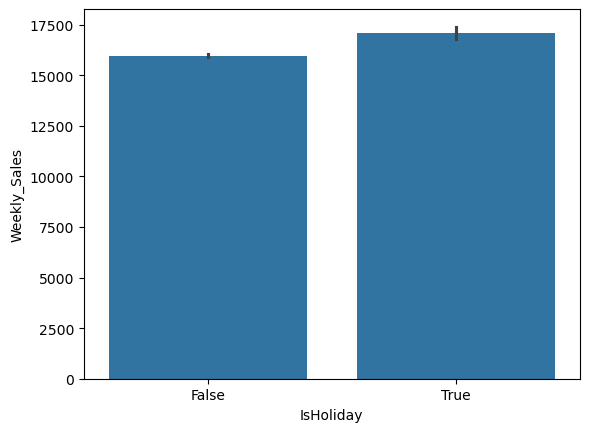

In [21]:
sns.barplot(x='IsHoliday', y='Weekly_Sales', data=df)

In [22]:
df_holiday = df.loc[df['IsHoliday']==True]
df_holiday['Date'].unique() 

array(['2010-02-12', '2010-09-10', '2010-11-26', '2010-12-31',
       '2011-02-11', '2011-09-09', '2011-11-25', '2011-12-30',
       '2012-02-10', '2012-09-07'], dtype=object)

In [23]:
df_not_holiday = df.loc[df['IsHoliday']==False]
df_not_holiday['Date'].nunique() 

133

All holidays are not in the data. There are 4 holiday values such as;

Super Bowl: 12-Feb-10, 11-Feb-11, 10-Feb-12, 8-Feb-13

Labor Day: 10-Sep-10, 9-Sep-11, 7-Sep-12, 6-Sep-13

Thanksgiving: 26-Nov-10, 25-Nov-11, 23-Nov-12, 29-Nov-13

Christmas: 31-Dec-10, 30-Dec-11, 28-Dec-12, 27-Dec-13


After the 07-Sep-2012 holidays are in test set for prediction. When we look at the data, average weekly sales for holidays are significantly higher than not-holiday days. In train data, there are 133 weeks for non-holiday and 10 weeks for holiday.

I want to see differences between holiday types. So, I create new columns for 4 types of holidays and fill them with boolean values. If date belongs to this type of holiday it is True, if not False. 

In [24]:
# Super bowl dates in train set
df.loc[(df['Date'] == '2010-02-12')|(df['Date'] == '2011-02-11')|(df['Date'] == '2012-02-10'),'Super_Bowl'] = True
df.loc[(df['Date'] != '2010-02-12')&(df['Date'] != '2011-02-11')&(df['Date'] != '2012-02-10'),'Super_Bowl'] = False

In [25]:
# Labor day dates in train set
df.loc[(df['Date'] == '2010-09-10')|(df['Date'] == '2011-09-09')|(df['Date'] == '2012-09-07'),'Labor_Day'] = True
df.loc[(df['Date'] != '2010-09-10')&(df['Date'] != '2011-09-09')&(df['Date'] != '2012-09-07'),'Labor_Day'] = False

In [26]:
# Thanksgiving dates in train set
df.loc[(df['Date'] == '2010-11-26')|(df['Date'] == '2011-11-25'),'Thanksgiving'] = True
df.loc[(df['Date'] != '2010-11-26')&(df['Date'] != '2011-11-25'),'Thanksgiving'] = False

In [27]:
#Christmas dates in train set
df.loc[(df['Date'] == '2010-12-31')|(df['Date'] == '2011-12-30'),'Christmas'] = True
df.loc[(df['Date'] != '2010-12-31')&(df['Date'] != '2011-12-30'),'Christmas'] = False

<Axes: xlabel='Christmas', ylabel='Weekly_Sales'>

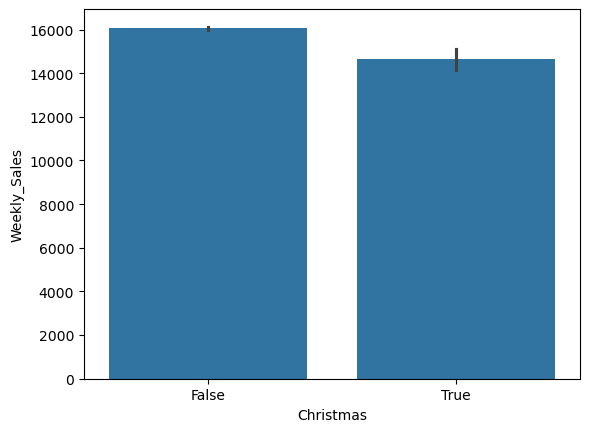

In [28]:
sns.barplot(x='Christmas', y='Weekly_Sales', data=df) # Christmas holiday vs not-Christmas

<Axes: xlabel='Thanksgiving', ylabel='Weekly_Sales'>

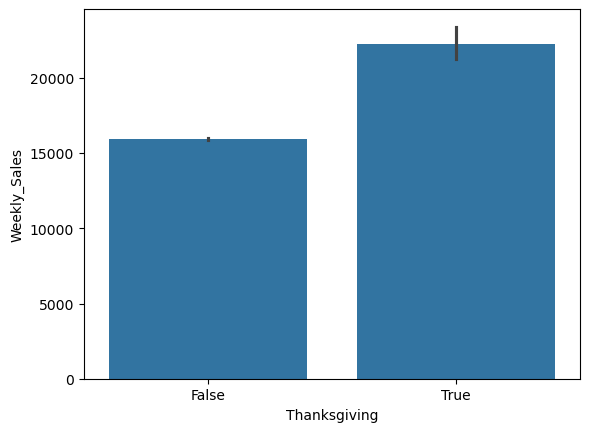

In [29]:
sns.barplot(x='Thanksgiving', y='Weekly_Sales', data=df) # Thanksgiving holiday vs not-thanksgiving

<Axes: xlabel='Super_Bowl', ylabel='Weekly_Sales'>

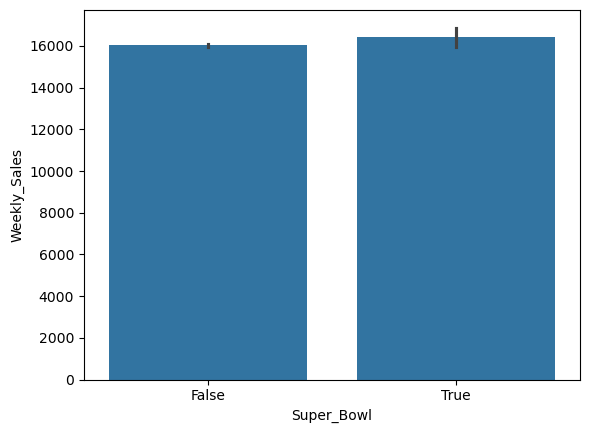

In [30]:
sns.barplot(x='Super_Bowl', y='Weekly_Sales', data=df) # Super bowl holiday vs not-super bowl

<Axes: xlabel='Labor_Day', ylabel='Weekly_Sales'>

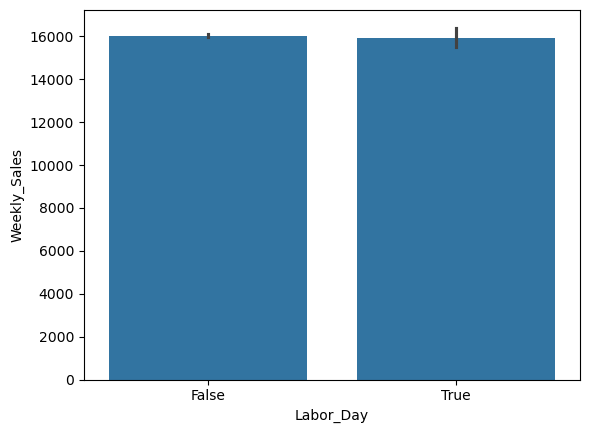

In [31]:
sns.barplot(x='Labor_Day', y='Weekly_Sales', data=df) # Labor day holiday vs not-labor day

It is shown that for the graphs, Labor Day and Christmas do not increase weekly average sales. There is positive effect on sales in Super bowl, but the highest difference is in the Thanksgiving. I think, people generally prefer to buy Christmas gifts 1-2 weeks before Christmas, so it does not change sales in the Christmas week. And, there is Black Friday sales in the Thanksgiving week.

# Type Effect on Holidays

There are three different store types in the data as A, B and C.

In [32]:
df.groupby(['Christmas','Type'])['Weekly_Sales'].mean()  # Avg weekly sales for types on Christmas 

Christmas  Type
False      A       20174.350209
           B       12301.986116
           C        9570.951973
True       A       18310.167535
           B       11488.988057
           C        8031.520607
Name: Weekly_Sales, dtype: float64

In [33]:
df.groupby(['Labor_Day','Type'])['Weekly_Sales'].mean()  # Avg weekly sales for types on Labor Day

Labor_Day  Type
False      A       20151.210941
           B       12294.954138
           C        9542.098293
True       A       20004.267422
           B       12084.304642
           C        9893.459258
Name: Weekly_Sales, dtype: float64

In [34]:
df.groupby(['Thanksgiving','Type'])['Weekly_Sales'].mean()  # Avg weekly sales for types on Thanksgiving

Thanksgiving  Type
False         A       20044.007801
              B       12197.717405
              C        9547.377807
True          A       27397.776346
              B       18733.973971
              C        9696.566616
Name: Weekly_Sales, dtype: float64

In [35]:
df.groupby(['Super_Bowl','Type'])['Weekly_Sales'].mean()  # Avg weekly sales for types on Super Bowl

Super_Bowl  Type
False       A       20138.055908
            B       12286.739293
            C        9536.110508
True        A       20612.757674
            B       12467.035506
            C       10179.271884
Name: Weekly_Sales, dtype: float64

I want to see percentages of store types.

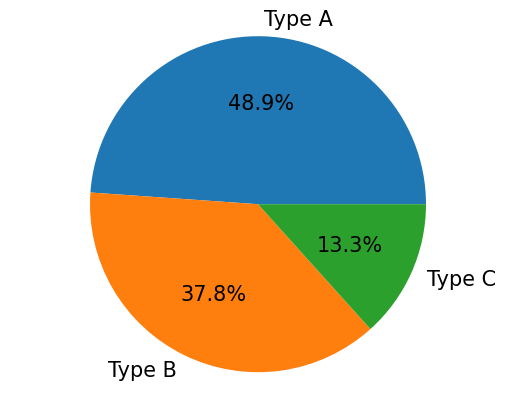

In [36]:
my_data = [48.88, 37.77 , 13.33 ]  #percentages
my_labels = 'Type A','Type B', 'Type C' # labels
plt.pie(my_data,labels=my_labels,autopct='%1.1f%%', textprops={'fontsize': 15}) #plot pie type and bigger the labels
plt.axis('equal')
mpl.rcParams.update({'font.size': 20}) #bigger percentage labels

plt.show()

In [37]:
df.groupby('IsHoliday')['Weekly_Sales'].mean()

IsHoliday
False    15952.816352
True     17094.300918
Name: Weekly_Sales, dtype: float64

Nearly, half of the stores are belongs to Type A.

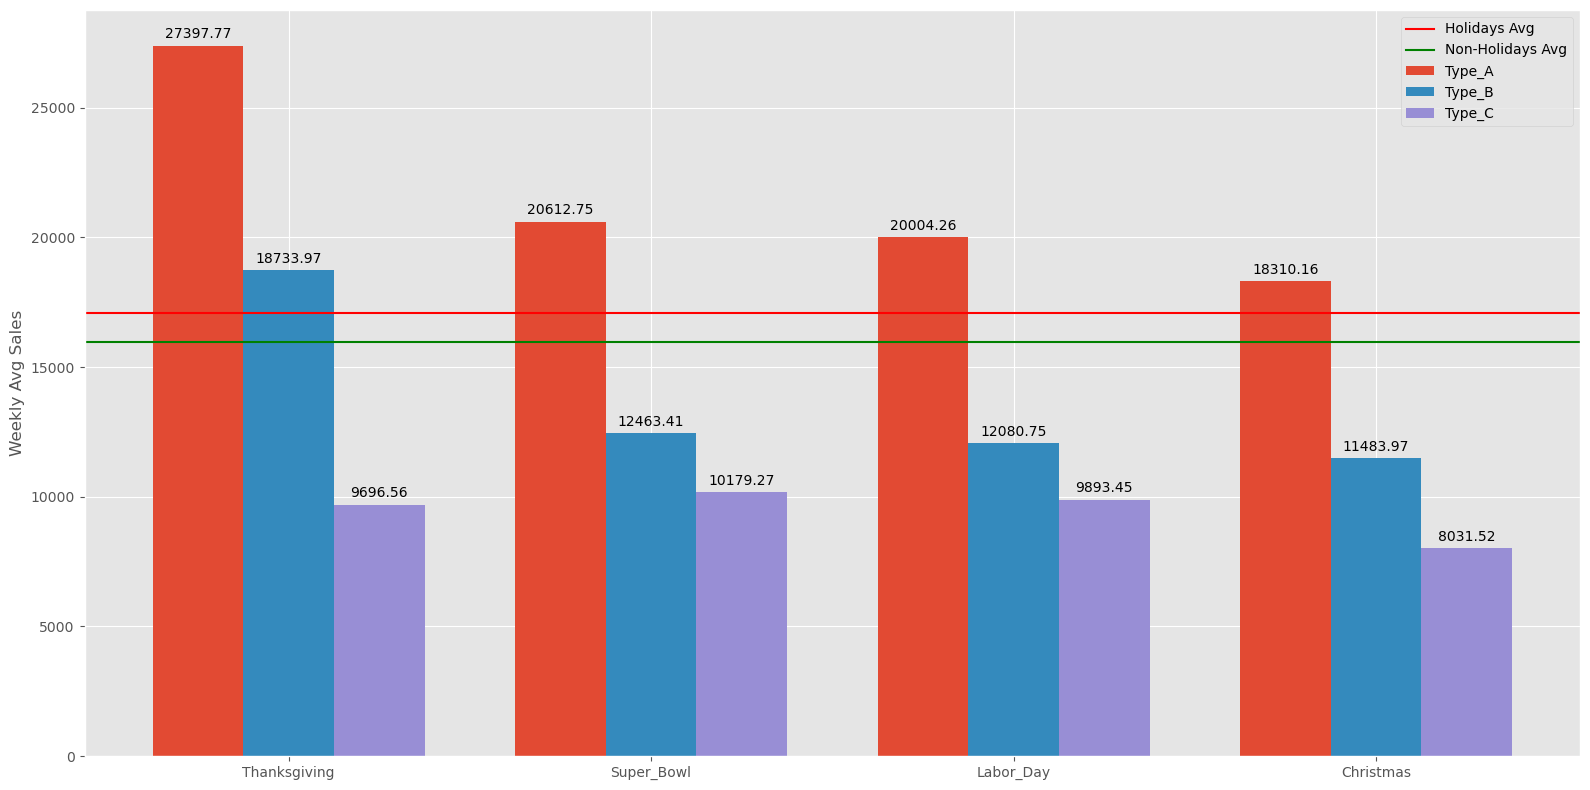

In [38]:
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('ggplot')  # Use a valid style
labels = ['Thanksgiving', 'Super_Bowl', 'Labor_Day', 'Christmas']
A_means = [27397.77, 20612.75, 20004.26, 18310.16]
B_means = [18733.97, 12463.41, 12080.75, 11483.97]
C_means = [9696.56, 10179.27, 9893.45, 8031.52]

x = np.arange(len(labels))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots(figsize=(16, 8))
rects1 = ax.bar(x - width, A_means, width, label='Type_A')
rects2 = ax.bar(x, B_means, width, label='Type_B')
rects3 = ax.bar(x + width, C_means, width, label='Type_C')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Weekly Avg Sales')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

plt.axhline(y=17094.30, color='r', label='Holidays Avg')  # holidays avg
plt.axhline(y=15952.82, color='green', label='Non-Holidays Avg')  # not-holiday avg
ax.legend()

fig.tight_layout()
plt.show()

In [39]:
#df['Date'].head(5).append(df['Date'].tail(5)) # to see first and last 5 rows.
pd.concat([df['Date'].head(5), df['Date'].tail(5)])


0         2010-02-05
1         2010-02-12
2         2010-02-19
3         2010-02-26
4         2010-03-05
421565    2012-09-28
421566    2012-10-05
421567    2012-10-12
421568    2012-10-19
421569    2012-10-26
Name: Date, dtype: object

It is seen from the graph that, highest sale average is in the Thanksgiving week between holidays. And, for all holidays Type A stores has highest sales.

In [40]:
df.sort_values(by='Weekly_Sales',ascending=False).head(5)

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,Super_Bowl,Labor_Day,Thanksgiving,Christmas
95373,10,72,2010-11-26,693099.36,True,55.33,3.162,NaN,NaN,NaN,NaN,NaN,126.669267,9.003,B,126512,False,False,True,False
338013,35,72,2011-11-25,649770.18,True,47.88,3.492,1333.24,NaN,58563.24,20.97,6386.86,140.421786,8.745,B,103681,False,False,True,False
95425,10,72,2011-11-25,630999.19,True,60.68,3.760,174.72,329.0,141630.61,79.00,1009.98,129.836400,7.874,B,126512,False,False,True,False
337961,35,72,2010-11-26,627962.93,True,46.67,3.039,NaN,NaN,NaN,NaN,NaN,136.689571,8.763,B,103681,False,False,True,False
135665,14,72,2010-11-26,474330.10,True,46.15,3.039,NaN,NaN,NaN,NaN,NaN,182.783277,8.724,A,200898,False,False,True,False


Also, it is not surprise that top 5 highest weekly sales are belongs to Thanksgiving weeks.

# To See the Size - Type Relation

In [41]:
df_store.groupby('Type').describe()['Size'].round(2) # See the Size-Type relation

,count,mean,std,min,25%,50%,75%,max
Type,,,,,,,,
A,22.0,177247.73,49392.62,39690.0,155840.75,202406.0,203819.0,219622.0
B,17.0,101190.71,32371.14,34875.0,93188.00,114533.0,123737.0,140167.0
C,6.0,40541.67,1304.15,39690.0,39745.00,39910.0,40774.0,42988.0


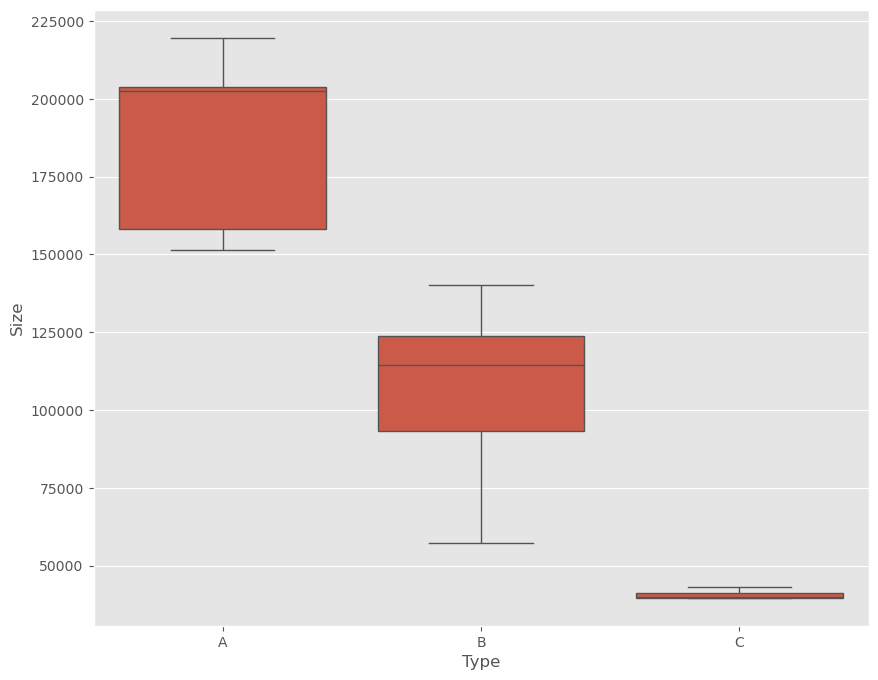

In [42]:
plt.figure(figsize=(10,8)) # To see the type-size relation
fig = sns.boxplot(x='Type', y='Size', data=df, showfliers=False)

Size of the type of stores are consistent with sales, as expected. Higher size stores has higher sales. And, Walmart classify stores according to their sizes according to graph. After the smallest size value of Type A, Type B begins. After the smallest size value of Type B, Type C begins.

# Markdown Columns

Walmart gave markdown columns to see the effect if markdowns on sales. When I check columns, there are many NaN values for markdowns. I decided to change them with 0, because if there is markdown in the row, it is shown with numbres. So, if I can write 0, it shows there is no markdown at that date.

In [43]:
df.isna().sum()

Store                0
Dept                 0
Date                 0
Weekly_Sales         0
IsHoliday            0
Temperature          0
Fuel_Price           0
MarkDown1       270031
MarkDown2       309308
MarkDown3       283561
MarkDown4       285694
MarkDown5       269283
CPI                  0
Unemployment         0
Type                 0
Size                 0
Super_Bowl           0
Labor_Day            0
Thanksgiving         0
Christmas            0
dtype: int64

In [44]:
df = df.fillna(0) # filling null's with 0

In [45]:
df.isna().sum() # last null check

Store           0
Dept            0
Date            0
Weekly_Sales    0
IsHoliday       0
Temperature     0
Fuel_Price      0
MarkDown1       0
MarkDown2       0
MarkDown3       0
MarkDown4       0
MarkDown5       0
CPI             0
Unemployment    0
Type            0
Size            0
Super_Bowl      0
Labor_Day       0
Thanksgiving    0
Christmas       0
dtype: int64

In [46]:
df.describe() # to see weird statistical things

,Store,Dept,Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Size
count,420212.000000,420212.000000,420212.000000,420212.000000,420212.000000,420212.000000,420212.000000,420212.000000,420212.000000,420212.000000,420212.000000,420212.000000,420212.000000
mean,22.195611,44.241309,16033.114591,60.090599,3.360890,2590.323565,878.905242,468.845949,1083.534361,1662.805002,171.212496,7.960000,136749.732787
std,12.787236,30.508819,22729.492116,18.447857,0.458519,6053.415601,5076.928566,5534.069859,3896.068938,4206.209357,39.162445,1.863879,60993.084568
min,1.000000,1.000000,0.010000,-2.060000,2.472000,0.000000,-265.760000,-29.100000,0.000000,0.000000,126.064000,3.879000,34875.000000
25%,11.000000,18.000000,2120.130000,46.680000,2.933000,0.000000,0.000000,0.000000,0.000000,0.000000,132.022667,6.891000,93638.000000
50%,22.000000,37.000000,7661.700000,62.090000,3.452000,0.000000,0.000000,0.000000,0.000000,0.000000,182.350989,7.866000,140167.000000
75%,33.000000,74.000000,20271.265000,74.280000,3.738000,2809.050000,2.400000,4.540000,425.290000,2168.040000,212.445487,8.567000,202505.000000
max,45.000000,99.000000,693099.360000,100.140000,4.468000,88646.760000,104519.540000,141630.610000,67474.850000,108519.280000,227.232807,14.313000,219622.000000


Minimum value for weekly sales is 0.01. Most probably, this value is not true but I prefer not to change them now. Because, there are many departments and many stores. It takes too much time to check each department for each store (45 store for 81 departments). So, I take averages for EDA. 

# Deeper Look in Sales

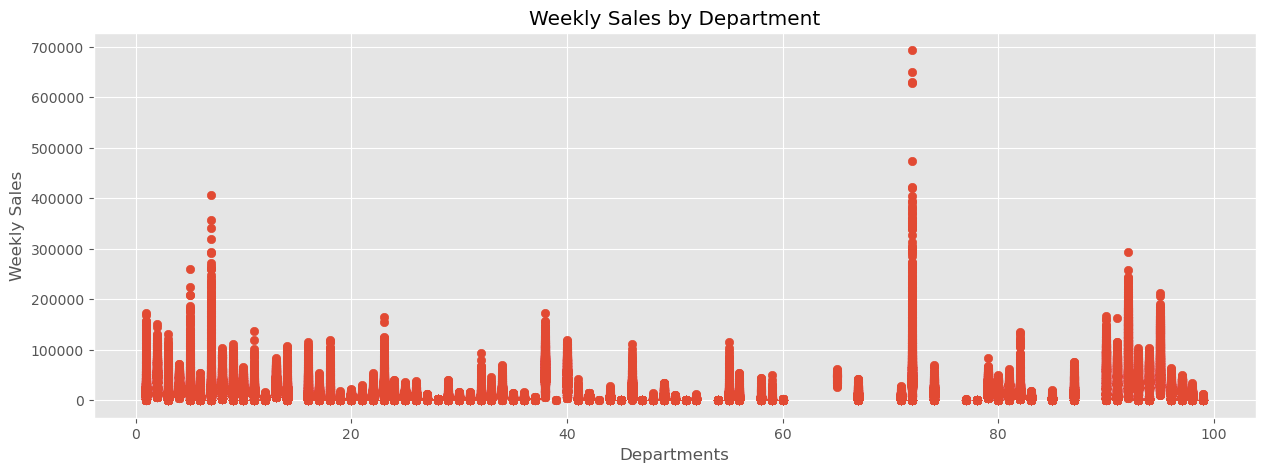

In [47]:
x = df['Dept']
y = df['Weekly_Sales']
plt.figure(figsize=(15,5))
plt.title('Weekly Sales by Department')
plt.xlabel('Departments')
plt.ylabel('Weekly Sales')
plt.scatter(x,y)
plt.show()

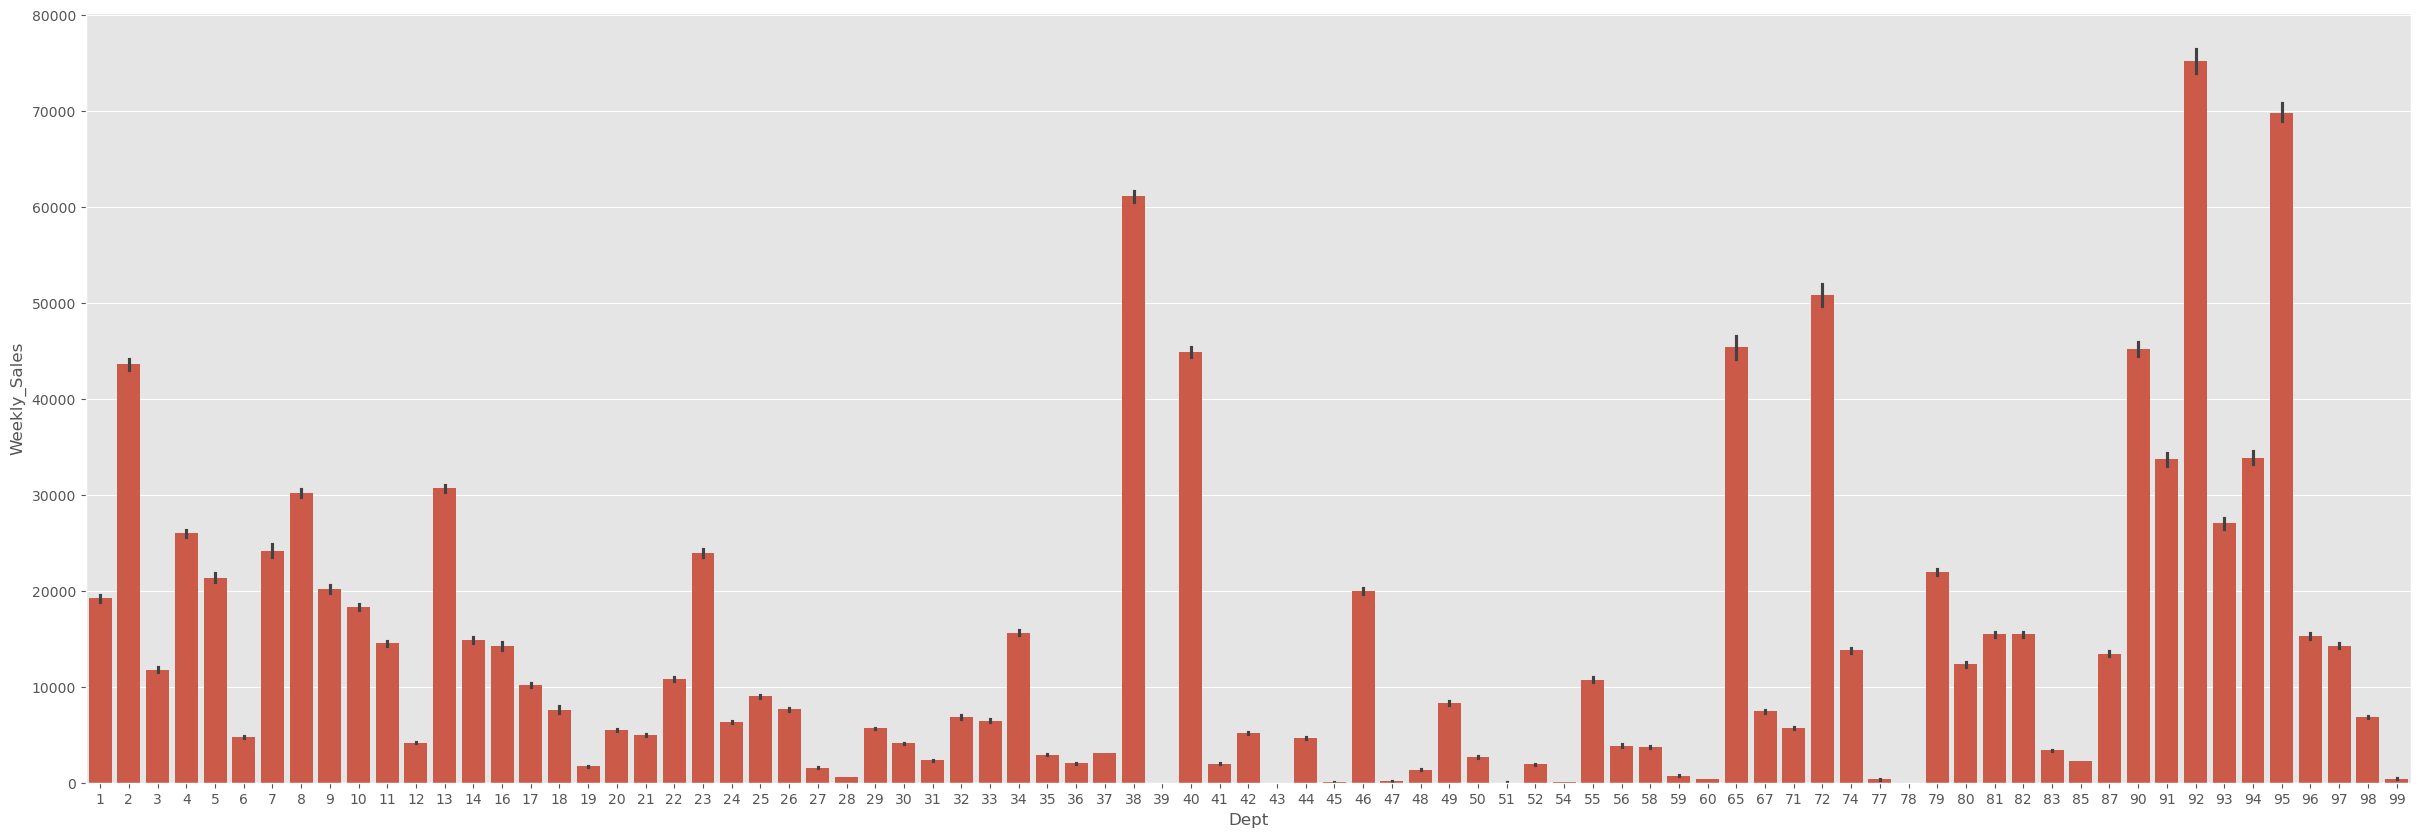

In [48]:
plt.figure(figsize=(30,10))
fig = sns.barplot(x='Dept', y='Weekly_Sales', data=df)

From the first graph, it is seen that one department between 60-80(I assume it is 72), has higher sales values. But, when we take the averages, it is seen that department 92 has higher mean sales. Department 72 is seasonal department, I think. It has higher values is some seasons but on average 92 is higher.

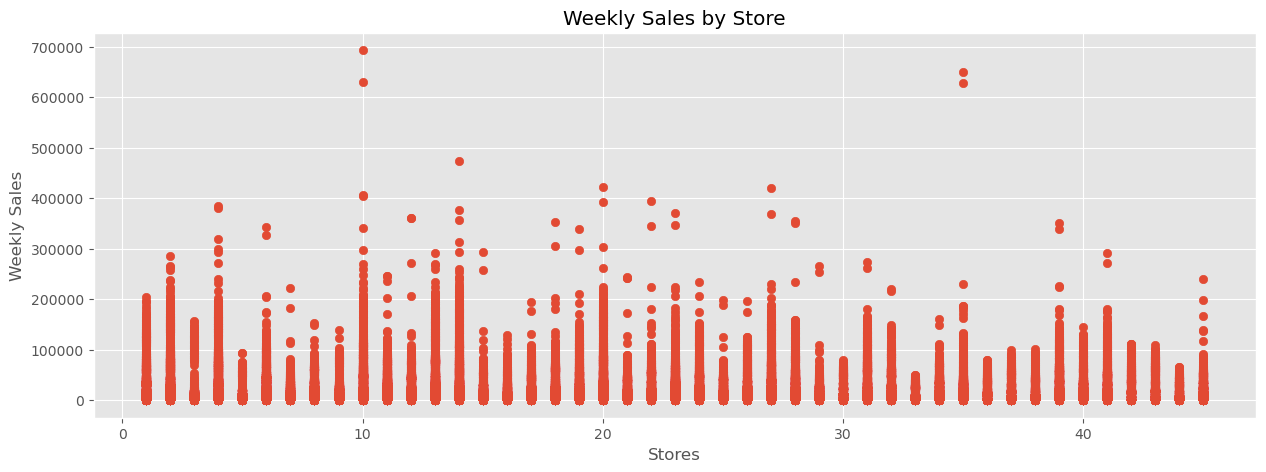

In [49]:
x = df['Store']
y = df['Weekly_Sales']
plt.figure(figsize=(15,5))
plt.title('Weekly Sales by Store')
plt.xlabel('Stores')
plt.ylabel('Weekly Sales')
plt.scatter(x,y)
plt.show()

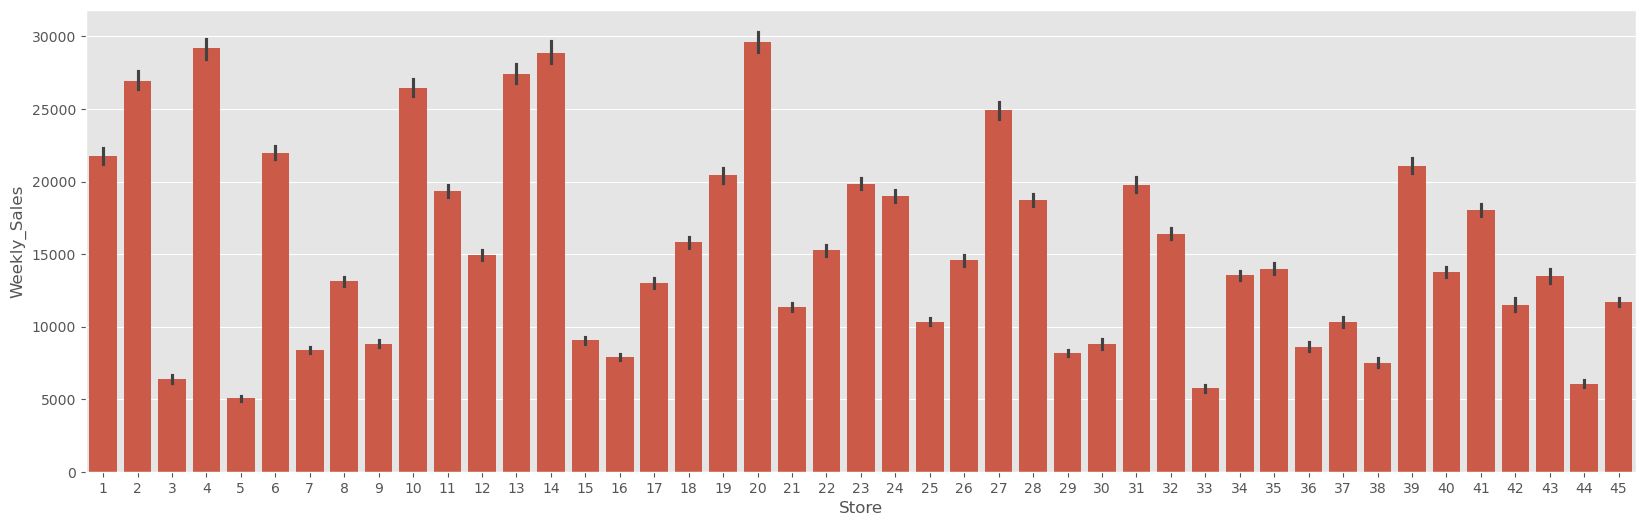

In [50]:
plt.figure(figsize=(20,6))
fig = sns.barplot(x='Store', y='Weekly_Sales', data=df)

Same thing happens in stores. From the first graph, some stores has higher sales but on average store 20 is the best and 4 and 14 following it.

# Changing Date to Datetime and Creating New Columns

In [51]:
df["Date"] = pd.to_datetime(df["Date"])  # Convert to datetime
df['week'] = df['Date'].dt.isocalendar().week  # Extract ISO week
df['month'] = df['Date'].dt.month  # Extract month
df['year'] = df['Date'].dt.year  # Extract year

In [52]:
df.groupby('month')['Weekly_Sales'].mean() # to see the best months for sales

month
1     14182.239153
2     16048.701191
3     15464.817698
4     15696.435193
5     15845.556200
6     16397.605478
7     15905.472425
8     16113.800069
9     15147.216063
10    15279.182119
11    17534.964277
12    19425.798603
Name: Weekly_Sales, dtype: float64

In [53]:
df.groupby('year')['Weekly_Sales'].mean() # to see the best years for sales

year
2010    16318.648285
2011    16007.797985
2012    15748.265005
Name: Weekly_Sales, dtype: float64

<Axes: xlabel='month'>

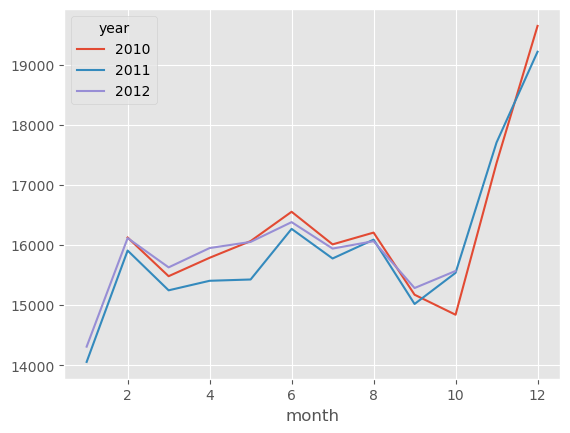

In [54]:
monthly_sales = pd.pivot_table(df, values = "Weekly_Sales", columns = "year", index = "month")
monthly_sales.plot()

From the graph, it is seen that 2011 has lower sales than 2010 generally. When we look at the mean sales it is seen that 2010 has higher values, but 2012 has no information about November and December which have higher sales. Despite of 2012 has no last two months sales, it's mean is near to 2010. Most probably, it will take the first place if we get 2012 results and add them.

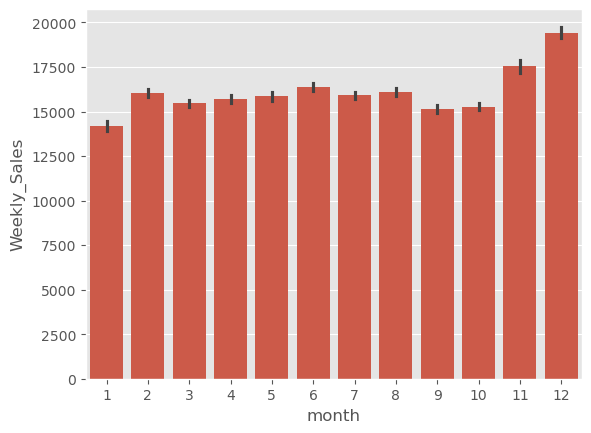

In [55]:
fig = sns.barplot(x='month', y='Weekly_Sales', data=df)

When we look at the graph above, the best sales are in December and November, as expected. The highest values are belongs to Thankgiving holiday but when we take average it is obvious that December has the best value.

In [56]:
df.groupby('week')['Weekly_Sales'].mean().sort_values(ascending=False).head()

week
51    26454.164116
47    22269.601768
50    20478.421134
49    18731.794840
22    16856.650245
Name: Weekly_Sales, dtype: float64

Top 5 sales averages by weekly belongs to 1-2 weeks before Christmas, Thanksgiving, Black Friday and end of May, when the schools are closed. 

<Axes: xlabel='week'>

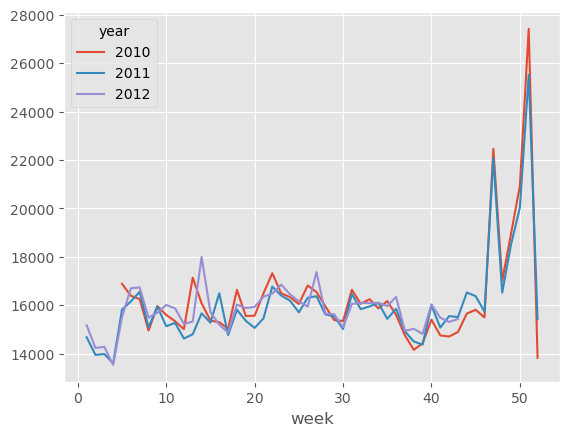

In [57]:
weekly_sales = pd.pivot_table(df, values = "Weekly_Sales", columns = "year", index = "week")
weekly_sales.plot()

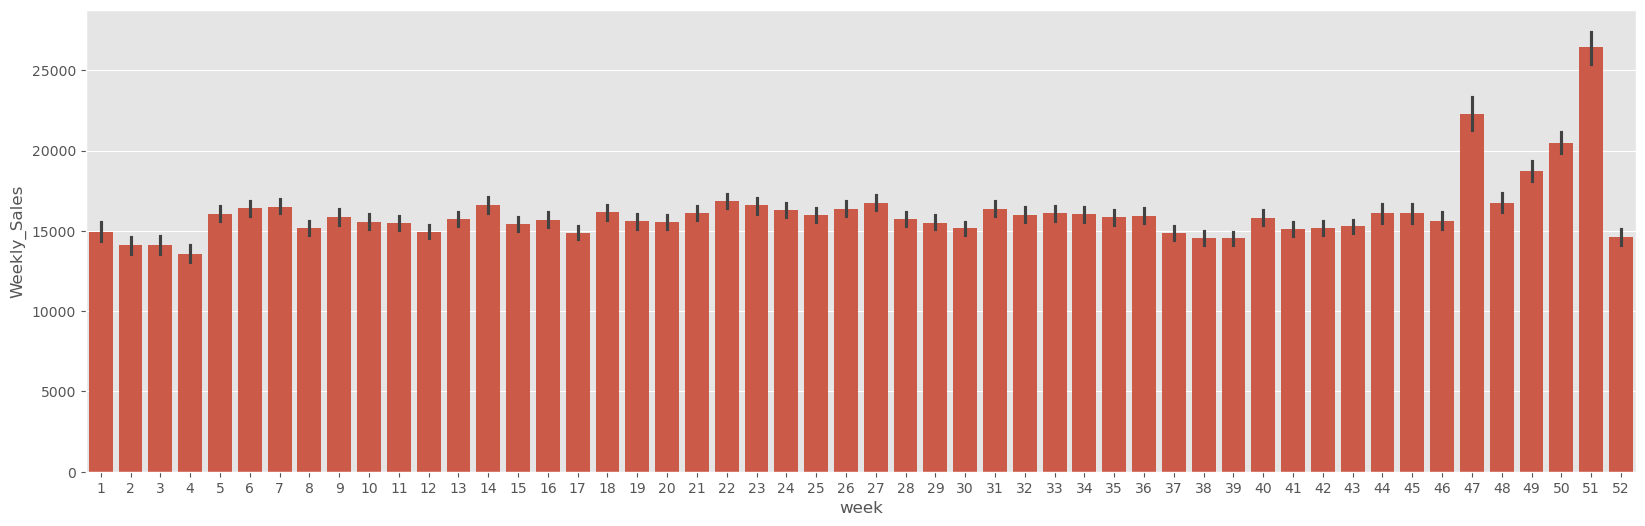

In [58]:
plt.figure(figsize=(20,6))
fig = sns.barplot(x='week', y='Weekly_Sales', data=df)

From graphs, it is seen that 51th week and 47th weeks have significantly higher averages as Christmas, Thankgiving and Black Friday effects.

# Fuel Price, CPI , Unemployment , Temperature Effects

<Axes: xlabel='Fuel_Price'>

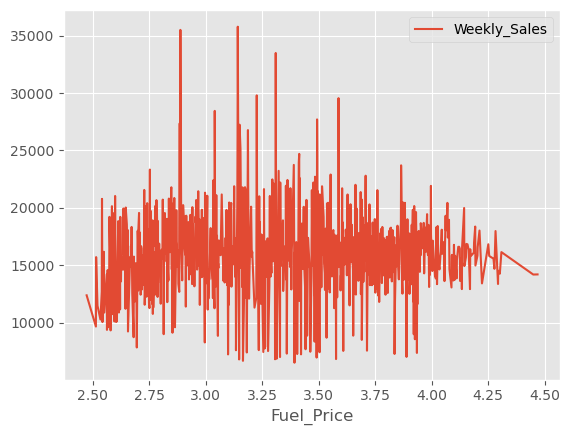

In [59]:
fuel_price = pd.pivot_table(df, values = "Weekly_Sales", index= "Fuel_Price")
fuel_price.plot()

<Axes: xlabel='Temperature'>

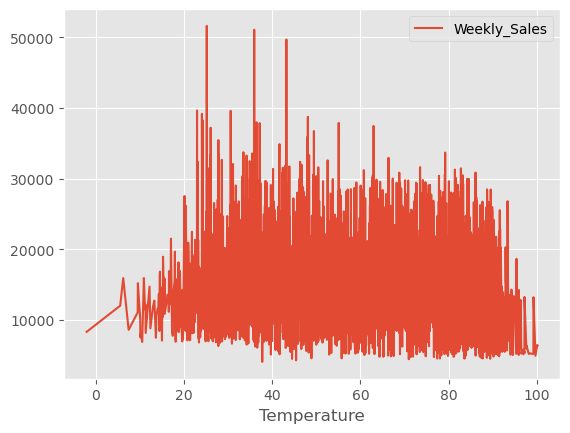

In [60]:
temp = pd.pivot_table(df, values = "Weekly_Sales", index= "Temperature")
temp.plot()

<Axes: xlabel='CPI'>

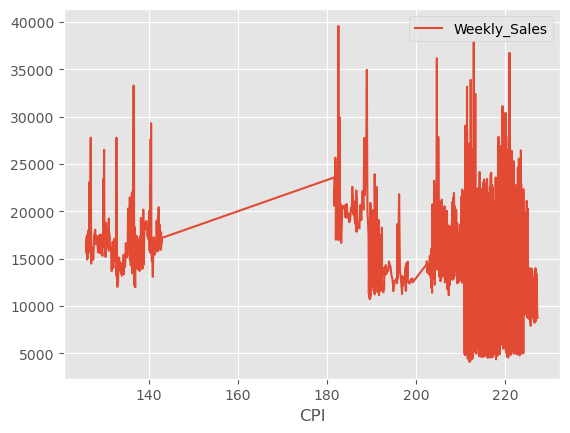

In [61]:
CPI = pd.pivot_table(df, values = "Weekly_Sales", index= "CPI")
CPI.plot()

<Axes: xlabel='Unemployment'>

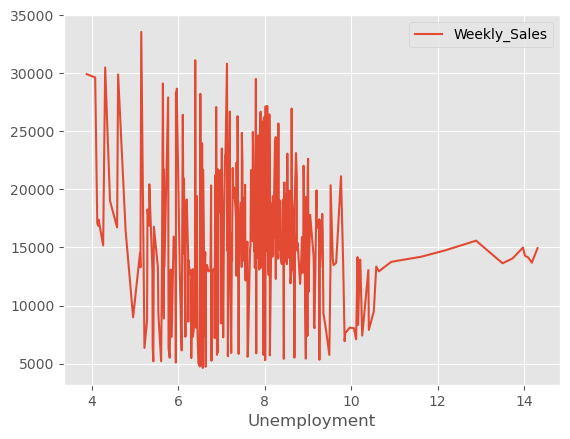

In [62]:
unemployment = pd.pivot_table(df, values = "Weekly_Sales", index= "Unemployment")
unemployment.plot()

From graphs, it is seen that there are no significant patterns between CPI, temperature, unemployment rate, fuel price vs weekly sales. There is no data for CPI between 140-180 also.

In [63]:
df.to_csv('clean_data.csv') # assign new data frame to csv for using after here

# Findings and Explorations

# Cleaning Process

- The data has no too much missing values. All columns was checked. 
- I choose rows which has higher than 0 weekly sales. Minus values are 0.3% of data. So, I dropped them.
- Null values in markdowns changed to zero. Because, they were written as null if there were no markdown on this department. 

# Explorations & Findings

- There are 45 stores and 81 department in data. Departments are not same in all stores. 
- Although department 72 has higher weekly sales values, on average department 92 is the best. It shows us, some departments has higher values as seasonal like Thanksgiving. It is consistant when we look at the top 5 sales in data, all of them belongs to 72th department at Thanksgiving holiday time. 
- Although stores 10 and 35 have higher weekly sales values sometimes, in general average store 20 and store 4 are on the first and second rank. It means that some areas has higher seasonal sales. 
- Stores has 3 types as A, B and C according to their sizes. Almost half of the stores are bigger than 150000 and categorized as A. According to type, sales of the stores are changing.
- As expected, holiday average sales are higher than normal dates.
- Christmas holiday introduces as the last days of the year. But people generally shop at 51th week. So, when we look at the total sales of holidays, Thankgiving has higher sales between them which was assigned by Walmart.
- Year 2010 has higher sales than 2011 and 2012. But, November and December sales are not in the data for 2012. Even without highest sale months, 2012 is not significantly less than 2010, so after adding last two months, it can be first.
- It is obviously seen that week 51 and 47 have higher values and 50-48 weeks follow them. Interestingly, 5th top sales belongs to 22th week of the year. This results show that Christmas, Thankgiving and Black Friday are very important than other weeks for sales and 5th important time is 22th week of the year and it is end of the May, when schools are closed. Most probably, people are preparing for holiday at the end of the May. 
- January sales are significantly less than other months. This is the result of November and December high sales. After two high sales month, people prefer to pay less on January.
- CPI, temperature, unemployment rate and fuel price have no pattern on weekly sales. 


# First Trial with Random Forest

Generally, Rondom Forest Regressor gives good results when we tune it well. So, to find simple baseline model, I will use RandomForestRegressor in this notebook. Also, feature importance for model can be found in this notebook. 

Our metric for this project is weighted mean absolute error (WMAE):

![title](https://miro.medium.com/max/990/1*VKYKK85ViLYUUjyOWVURfw.jpeg)

where

- n is the number of rows
- ŷ i is the predicted sales
- yi is the actual sales
- wi are weights. w = 5 if the week is a holiday week, 1 otherwise

With this metric, the error at holiday weeks has 5 times weight more than normal weeks. So, it is more important to predict sales at holiday weeks accurately.
All results for trails can be found at the end of this notebook.

In [64]:
pd.options.display.max_columns=100 # to see columns 

In [65]:
df = pd.read_csv('./clean_data.csv')

In [66]:
df.drop(columns=['Unnamed: 0'],inplace=True)

In [67]:
df['Date'] = pd.to_datetime(df['Date']) # changing datetime to divide if needs

# Encoding the Data 

For preprocessing our data, I will change holidays boolean values to 0-1 and replace type of the stores from A, B, C to 1, 2, 3. 

In [68]:
df_encoded = df.copy() # to keep original dataframe taking copy of it

In [69]:
type_group = {'A':1, 'B': 2, 'C': 3}  # changing A,B,C to 1-2-3
df_encoded['Type'] = df_encoded['Type'].replace(type_group)

In [70]:
df_encoded['Super_Bowl'] = df_encoded['Super_Bowl'].astype(bool).astype(int) # changing T,F to 0-1

In [71]:
df_encoded['Thanksgiving'] = df_encoded['Thanksgiving'].astype(bool).astype(int) # changing T,F to 0-1

In [72]:
df_encoded['Labor_Day'] = df_encoded['Labor_Day'].astype(bool).astype(int) # changing T,F to 0-1

In [73]:
df_encoded['Christmas'] = df_encoded['Christmas'].astype(bool).astype(int) # changing T,F to 0-1

In [74]:
df_encoded['IsHoliday'] = df_encoded['IsHoliday'].astype(bool).astype(int) # changing T,F to 0-1

In [75]:
df_new = df_encoded.copy() # taking the copy of encoded df to keep it original

# Observation of Interactions between Features

Firstly, i will drop divided holiday columns from my data and try without them. To keep my encoded data safe, I assigned my dataframe to new one and I will use for this. 

In [76]:
drop_col = ['Super_Bowl','Labor_Day','Thanksgiving','Christmas']
df_new.drop(drop_col, axis=1, inplace=True) # dropping columns

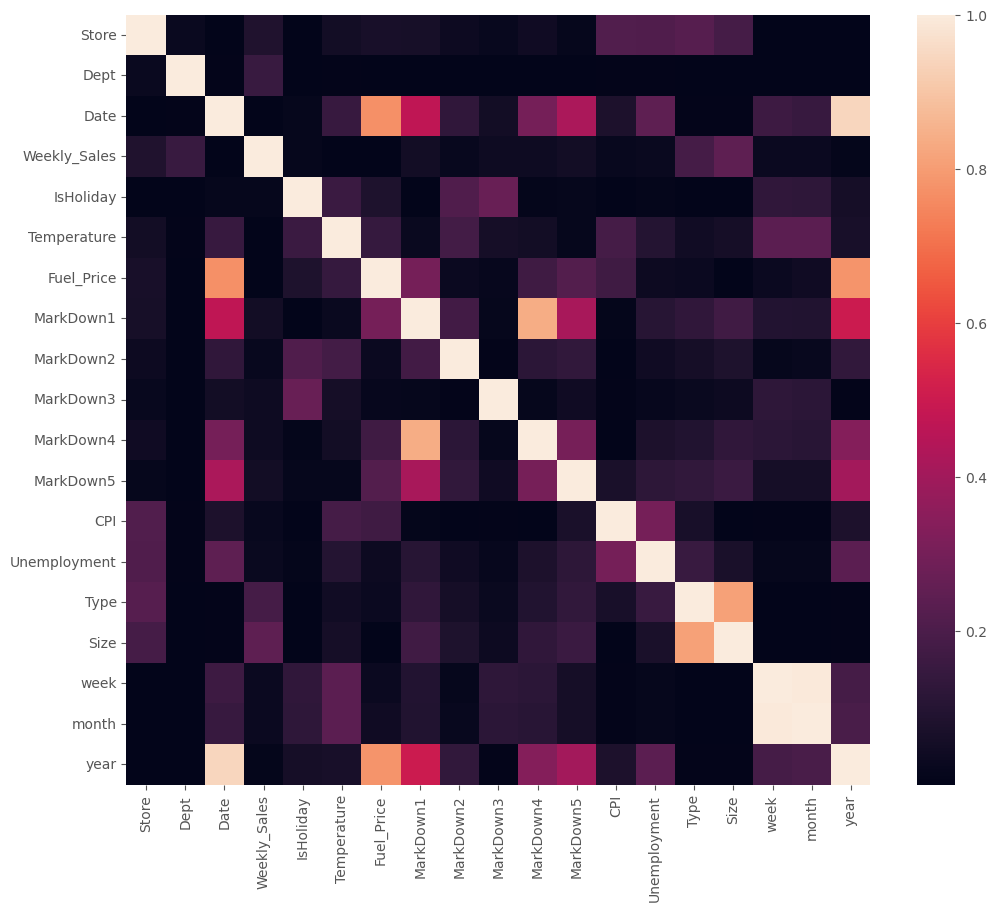

In [77]:
plt.figure(figsize = (12,10))
sns.heatmap(df_new.corr().abs())    # To see the correlations
plt.show()

Temperature, unemployment, CPI have no significant effect on weekly sales, so I will drop them. Also, Markdown 4 and 5 highly correlated with Markdown 1. So, I will drop them also. It can create multicollinearity problem, maybe. So, first I will try without them.

In [78]:
drop_col = ['Temperature','MarkDown4','MarkDown5','CPI','Unemployment']
df_new.drop(drop_col, axis=1, inplace=True) # dropping columns

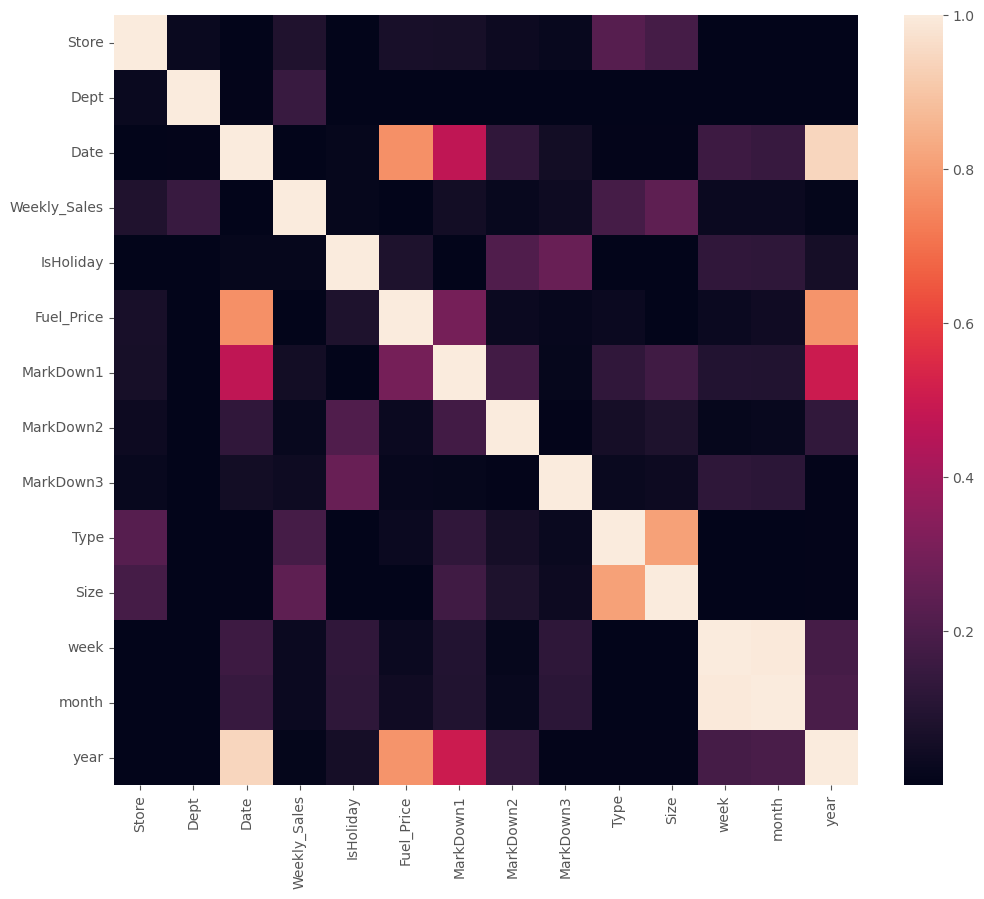

In [79]:
plt.figure(figsize = (12,10))
sns.heatmap(df_new.corr().abs())    # To see the correlations without dropping columns
plt.show()

Size and type are highly correlated with weekly sales. Also, department and store are correlated with sales.

In [80]:
df_new = df_new.sort_values(by='Date', ascending=True) # sorting according to date

# Creating Train-Test Splits

Our date column has continuos values, to keep the date features continue, I will not take random splitting. so, I split data manually according to 70%.

In [81]:
train_data = df_new[:int(0.7*(len(df_new)))] # taking train part
test_data = df_new[int(0.7*(len(df_new))):] # taking test part

target = "Weekly_Sales"
used_cols = [c for c in df_new.columns.to_list() if c not in [target]] # all columns except weekly sales

X_train = train_data[used_cols]
X_test = test_data[used_cols]
y_train = train_data[target]
y_test = test_data[target]

In [82]:
X = df_new[used_cols] # to keep train and test X values together

We have enough information in our date such as week of the year. So, I drop date columns.

In [83]:
X_train = X_train.drop(['Date'], axis=1) # dropping date from train
X_test = X_test.drop(['Date'], axis=1) # dropping date from test

# Metric Definition Function

Our metric is not calculated as default from ready models. It is weighed error so, I will use function below to calculate it.

In [84]:
def wmae_test(test, pred): # WMAE for test 
    weights = X_test['IsHoliday'].apply(lambda is_holiday:5 if is_holiday else 1)
    error = np.sum(weights * np.abs(test - pred), axis=0) / np.sum(weights)
    return error

# Random Forest Regressor

To tune the regressor, I can use gridsearch but it takes too much time for this type of data which has many rows and columns. So, I choose regressor parameters manually. I changed the parameters each time and try to find the best result.

In [85]:
rf = RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=-1, max_depth=35,
                           max_features = 'sqrt',min_samples_split = 10)

from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()



#making pipe tp use scaler and regressor together
pipe = make_pipeline(scaler,rf)

pipe.fit(X_train, y_train)

# predictions on train set
y_pred = pipe.predict(X_train)

# predictions on test set
y_pred_test = pipe.predict(X_test)

In [86]:
wmae_test(y_test, y_pred_test)

5680.1239911472085

For the first trial, my weighted error is around 5850.

# To See Feature Importance

In [87]:
X = X.drop(['Date'], axis=1) #dropping date column from X

Below code cell was taken from our instructor Bryan Arnold's notebook. I changed the code according to my data and see the plot.

Feature ranking:
1. feature 1 (0.733058)
2. feature 8 (0.109850)
3. feature 0 (0.055522)
4. feature 7 (0.037639)
5. feature 9 (0.021446)
6. feature 3 (0.018735)
7. feature 10 (0.008768)
8. feature 6 (0.005361)
9. feature 4 (0.003152)
10. feature 5 (0.002604)
11. feature 2 (0.002280)
12. feature 11 (0.001587)


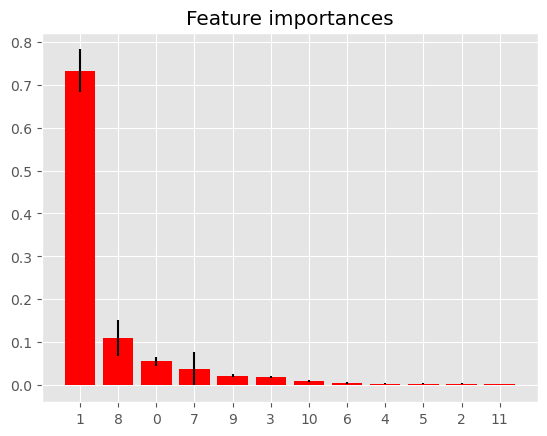

In [88]:
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Printing the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plotting the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

After looking feature importance, I dropped least important 3-4 features and tried the model. I found the best result when I dropped month column which is highly correlated with week.

In [89]:
X1_train = X_train.drop(['month'], axis=1) # dropping month
X1_test = X_test.drop(['month'], axis=1)

# Model Again without Month

In [90]:
rf = RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=-1, max_depth=35,
                           max_features = 'sqrt',min_samples_split = 10)

scaler=RobustScaler()
pipe = make_pipeline(scaler,rf)

pipe.fit(X1_train, y_train)

# predictions on train set
y_pred = pipe.predict(X1_train)

# predictions on test set
y_pred_test = pipe.predict(X1_test)

In [91]:
wmae_test(y_test, y_pred_test)

5596.9867246903195

It gives better results than baseline.

# Model with Whole Data

Now, I want to make sure that my model will learn from the columns which I dropped or not. So, I will apply my model to whole encoded data again.

In [92]:
# splitting train-test to whole dataset
train_data_enc = df_encoded[:int(0.7*(len(df_encoded)))]
test_data_enc = df_encoded[int(0.7*(len(df_encoded))):]

target = "Weekly_Sales"
used_cols1 = [c for c in df_encoded.columns.to_list() if c not in [target]] # all columns except price

X_train_enc = train_data_enc[used_cols1]
X_test_enc = test_data_enc[used_cols1]
y_train_enc = train_data_enc[target]
y_test_enc = test_data_enc[target]

In [93]:
X_enc = df_encoded[used_cols1] # to get together train,test splits

In [94]:
X_enc = X_enc.drop(['Date'], axis=1) #dropping date column for whole X

In [95]:
X_train_enc = X_train_enc.drop(['Date'], axis=1) # dropping date from train and test
X_test_enc= X_test_enc.drop(['Date'], axis=1)

In [96]:
rf = RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=-1, max_depth=35,
                           max_features = 'sqrt',min_samples_split = 10)

scaler=RobustScaler()
pipe = make_pipeline(scaler,rf)

pipe.fit(X_train_enc, y_train_enc)

# predictions on train set
y_pred_enc = pipe.predict(X_train_enc)

# predictions on test set
y_pred_test_enc = pipe.predict(X_test_enc)

In [97]:
wmae_test(y_test_enc, y_pred_test_enc)

2636.261203980676

We found better results for whole data, it means our model can learn from columns which I dropped before.

# Feature Importance for Whole Encoded Dataset

Feature ranking:
1. feature 1 (0.737846)
2. feature 13 (0.083957)
3. feature 12 (0.037083)
4. feature 0 (0.030890)
5. feature 10 (0.029541)
6. feature 11 (0.018256)
7. feature 18 (0.012616)
8. feature 3 (0.011369)
9. feature 4 (0.010234)
10. feature 19 (0.005422)
11. feature 7 (0.004556)
12. feature 9 (0.003819)
13. feature 5 (0.003549)
14. feature 8 (0.003523)
15. feature 6 (0.002499)
16. feature 16 (0.001423)
17. feature 20 (0.001219)
18. feature 2 (0.000974)
19. feature 17 (0.000634)
20. feature 15 (0.000298)
21. feature 14 (0.000291)


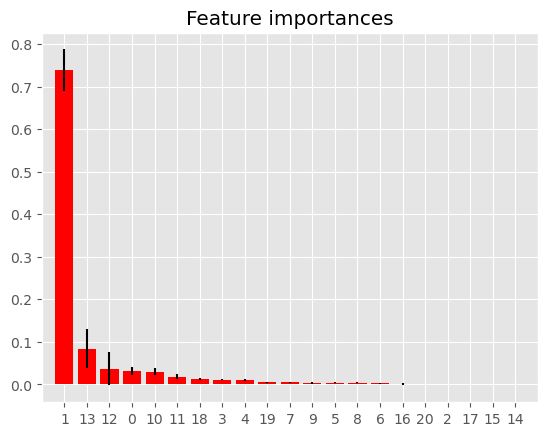

In [98]:
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Printing the feature ranking
print("Feature ranking:")

for f in range(X_enc.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plotting the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_enc.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X_enc.shape[1]), indices)
plt.xlim([-1, X_enc.shape[1]])
plt.show()

According to feature importance, I dropped some columns from whole set and try my model again.

In [99]:
df_encoded_new = df_encoded.copy() # taking copy of encoded data to keep it without change.
df_encoded_new.drop(drop_col, axis=1, inplace=True)

# Model According to Feature Importance

In [100]:
#train-test splitting
train_data_enc_new = df_encoded_new[:int(0.7*(len(df_encoded_new)))]
test_data_enc_new = df_encoded_new[int(0.7*(len(df_encoded_new))):]

target = "Weekly_Sales"
used_cols2 = [c for c in df_encoded_new.columns.to_list() if c not in [target]] # all columns except price

X_train_enc1 = train_data_enc_new[used_cols2]
X_test_enc1 = test_data_enc_new[used_cols2]
y_train_enc1 = train_data_enc_new[target]
y_test_enc1 = test_data_enc_new[target]

#droping date from train-test
X_train_enc1 = X_train_enc1.drop(['Date'], axis=1)
X_test_enc1= X_test_enc1.drop(['Date'], axis=1)

In [101]:
rf = RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=-1, max_depth=40,
                           max_features = 'log2',min_samples_split = 10)

scaler=RobustScaler()
pipe = make_pipeline(scaler,rf)

pipe.fit(X_train_enc1, y_train_enc1)

# predictions on train set
y_pred_enc = pipe.predict(X_train_enc1)

# predictions on test set
y_pred_test_enc = pipe.predict(X_test_enc1)

In [102]:
pipe.score(X_test_enc1,y_test_enc1)

0.7328393097758756

In [103]:
wmae_test(y_test_enc1, y_pred_test_enc)

2008.1077860698256

I found best results with doing feature selection from whole encoded dataset.

# Model with Dropping Month Column

With the same dateset before, I try to model again without month column. 

In [104]:
df_encoded_new1 = df_encoded.copy()
df_encoded_new1.drop(drop_col, axis=1, inplace=True)

In [105]:
df_encoded_new1 = df_encoded_new1.drop(['Date'], axis=1)

In [106]:
df_encoded_new1 = df_encoded_new1.drop(['month'], axis=1)

In [107]:
#train-test split
train_data_enc_new1 = df_encoded_new1[:int(0.7*(len(df_encoded_new1)))]
test_data_enc_new1 = df_encoded_new1[int(0.7*(len(df_encoded_new1))):]

target = "Weekly_Sales"
used_cols3 = [c for c in df_encoded_new1.columns.to_list() if c not in [target]] # all columns except price

X_train_enc2 = train_data_enc_new1[used_cols3]
X_test_enc2 = test_data_enc_new1[used_cols3]
y_train_enc2 = train_data_enc_new1[target]
y_test_enc2 = test_data_enc_new1[target]

In [108]:
#modeling part
pipe = make_pipeline(scaler,rf)

pipe.fit(X_train_enc2, y_train_enc2)

# predictions on train set
y_pred_enc = pipe.predict(X_train_enc2)

# predictions on test set
y_pred_test_enc = pipe.predict(X_test_enc2)

In [109]:
pipe.score(X_test_enc2,y_test_enc2)

0.709632210516314

In [110]:
wmae_test(y_test_enc2, y_pred_test_enc)

2219.1237434556956

It did not give better results than before.

In [111]:
df_results = pd.DataFrame(columns=["Model", "Info",'WMAE']) # result df for showing results together

In [112]:
# writing results to df
new_row = {
    "Model": 'RandomForestRegressor',
    "Info": 'w/out divided holiday columns',
    "WMAE": 5850
}

df_results = pd.concat([df_results, pd.DataFrame([new_row])], ignore_index=True)

In [113]:
# Create a list of dictionaries for the new rows
new_rows = [
    {"Model": 'RandomForestRegressor', "Info": 'w/out month column', 'WMAE': 5494},
    {"Model": 'RandomForestRegressor', "Info": 'whole data', 'WMAE': 2450},
    {"Model": 'RandomForestRegressor', "Info": 'whole data with feature selection', 'WMAE': 1801},
    {"Model": 'RandomForestRegressor', "Info": 'whole data with feature selection w/out month', 'WMAE': 2093}
]

# Convert the list of dictionaries to a DataFrame and concatenate it with df_results
df_results = pd.concat([df_results, pd.DataFrame(new_rows)], ignore_index=True)

In [114]:
df_results

,Model,Info,WMAE
0,RandomForestRegressor,w/out divided holiday columns,5850
1,RandomForestRegressor,w/out month column,5494
2,RandomForestRegressor,whole data,2450
3,RandomForestRegressor,whole data with feature selection,1801
4,RandomForestRegressor,whole data with feature selection w/out month,2093


The best results belongs to whole data set with feature selection. Now, I will try time series models.

# Time Series Models

In [115]:
df.head() # to see my data

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,Super_Bowl,Labor_Day,Thanksgiving,Christmas,week,month,year
0,1,1,2010-02-05,24924.50,False,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,A,151315,False,False,False,False,5,2,2010
1,1,1,2010-02-12,46039.49,True,38.51,2.548,0.0,0.0,0.0,0.0,0.0,211.242170,8.106,A,151315,True,False,False,False,6,2,2010
2,1,1,2010-02-19,41595.55,False,39.93,2.514,0.0,0.0,0.0,0.0,0.0,211.289143,8.106,A,151315,False,False,False,False,7,2,2010
3,1,1,2010-02-26,19403.54,False,46.63,2.561,0.0,0.0,0.0,0.0,0.0,211.319643,8.106,A,151315,False,False,False,False,8,2,2010
4,1,1,2010-03-05,21827.90,False,46.50,2.625,0.0,0.0,0.0,0.0,0.0,211.350143,8.106,A,151315,False,False,False,False,9,3,2010


In [116]:
df["Date"] = pd.to_datetime(df["Date"]) #changing data to datetime for decomposing

In [117]:
df.set_index('Date', inplace=True) #seting date as index

# Plotting Sales

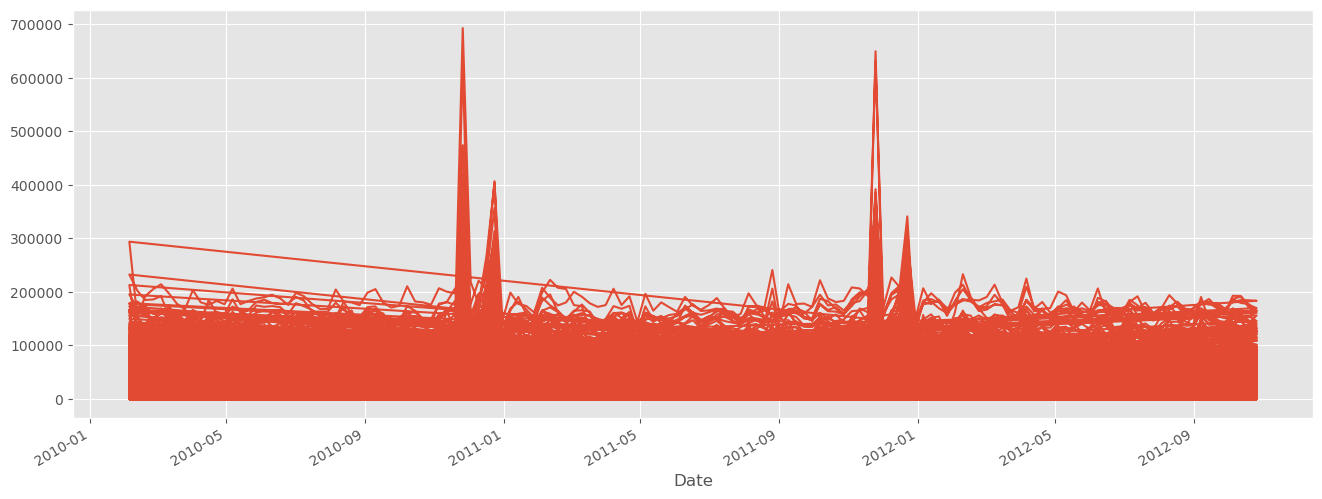

In [118]:
plt.figure(figsize=(16,6))
df['Weekly_Sales'].plot()
plt.show()

In this data, there are lots of same data values. So, I will collect them together as weekly.

In [119]:
# Select only numeric columns before resampling
df_week = df.select_dtypes(include='number').resample('W').mean()

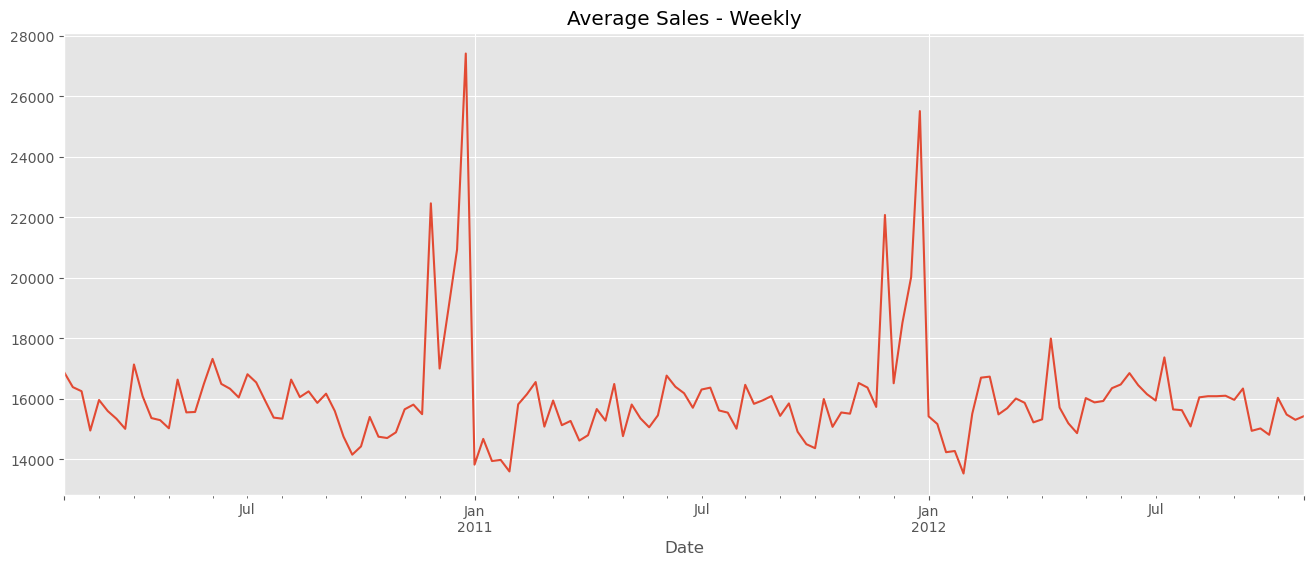

In [120]:
plt.figure(figsize=(16,6))
df_week['Weekly_Sales'].plot()
plt.title('Average Sales - Weekly')
plt.show()

With the collecting data as weekly, I can see average sales clearly. To see monthly pattern , I resampled my data to monthly also.

In [121]:
# Select only numeric columns before resampling
df_month = df.select_dtypes(include='number').resample('MS').mean()

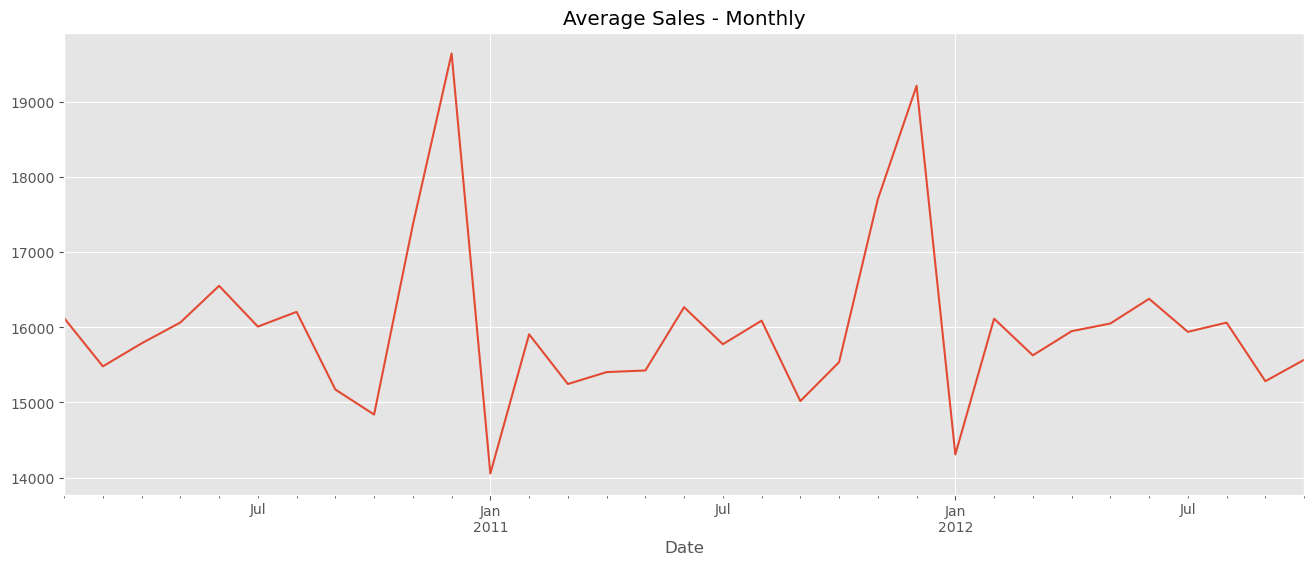

In [122]:
plt.figure(figsize=(16,6))
df_month['Weekly_Sales'].plot()
plt.title('Average Sales - Monthly')
plt.show()

When I turned data to monthly, I realized that I lost some patterns in weekly data. So, I will continue with weekly resampled data.

# To Observe 2-weeks Rolling Mean and Std

My data is non-stationary. So, I will try to find more stationary version on it. 

In [123]:
# finding 2-weeks rolling mean and std
roll_mean = df_week['Weekly_Sales'].rolling(window=2, center=False).mean()
roll_std = df_week['Weekly_Sales'].rolling(window=2, center=False).std()

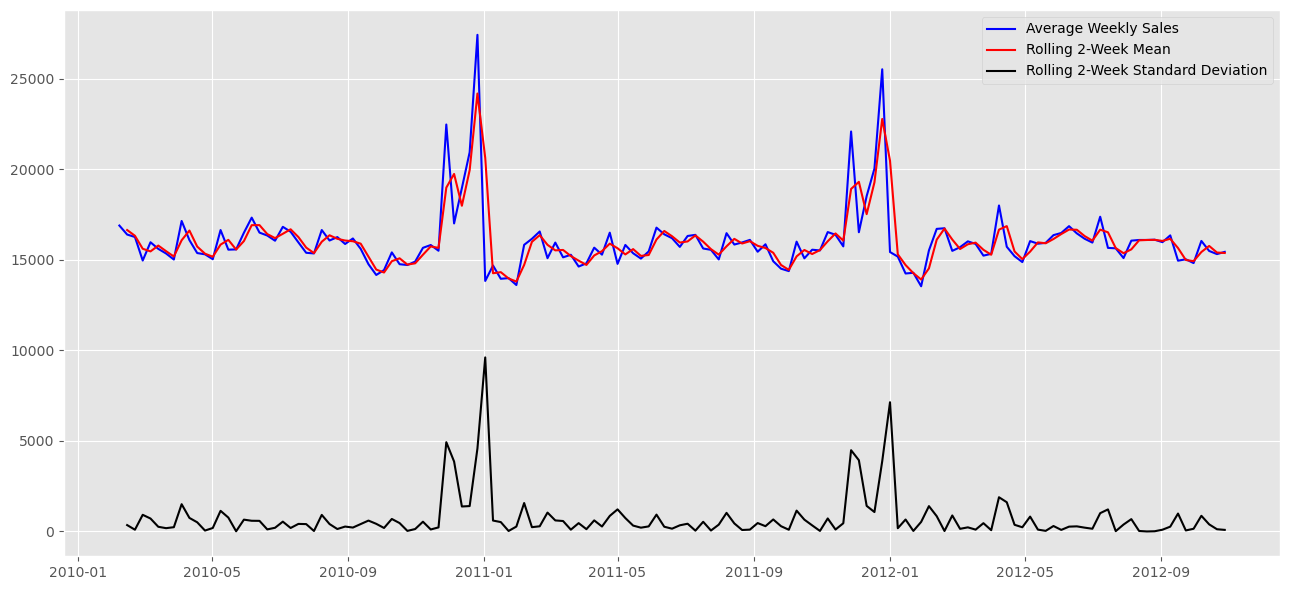

In [124]:
fig, ax = plt.subplots(figsize=(13, 6))
ax.plot(df_week['Weekly_Sales'], color='blue',label='Average Weekly Sales')
ax.plot(roll_mean, color='red', label='Rolling 2-Week Mean')
ax.plot(roll_std, color='black', label='Rolling 2-Week Standard Deviation')
ax.legend()
fig.tight_layout()

# Adfuller Test to Make Sure

In [125]:
adfuller(df_week['Weekly_Sales'])

(-5.927107223737573,
 2.429049208204236e-07,
 4,
 138,
 {'1%': -3.47864788917503,
  '5%': -2.882721765644168,
  '10%': -2.578065326612056},
 2261.596421168073)

From test and my observations my data is not stationary. So, I will try to find more stationary version of it.

# Train - Test Split of Weekly Data

To take train-test splits continuosly, I split them manually, not random.

In [126]:
train_data = df_week[:int(0.7*(len(df_week)))] 
test_data = df_week[int(0.7*(len(df_week))):]

print('Train:', train_data.shape)
print('Test:', test_data.shape)

Train: (100, 16)
Test: (43, 16)


In [127]:
target = "Weekly_Sales"
used_cols = [c for c in df_week.columns.to_list() if c not in [target]] # all columns except price

# assigning train-test X-y values

X_train = train_data[used_cols]
X_test = test_data[used_cols]
y_train = train_data[target]
y_test = test_data[target]

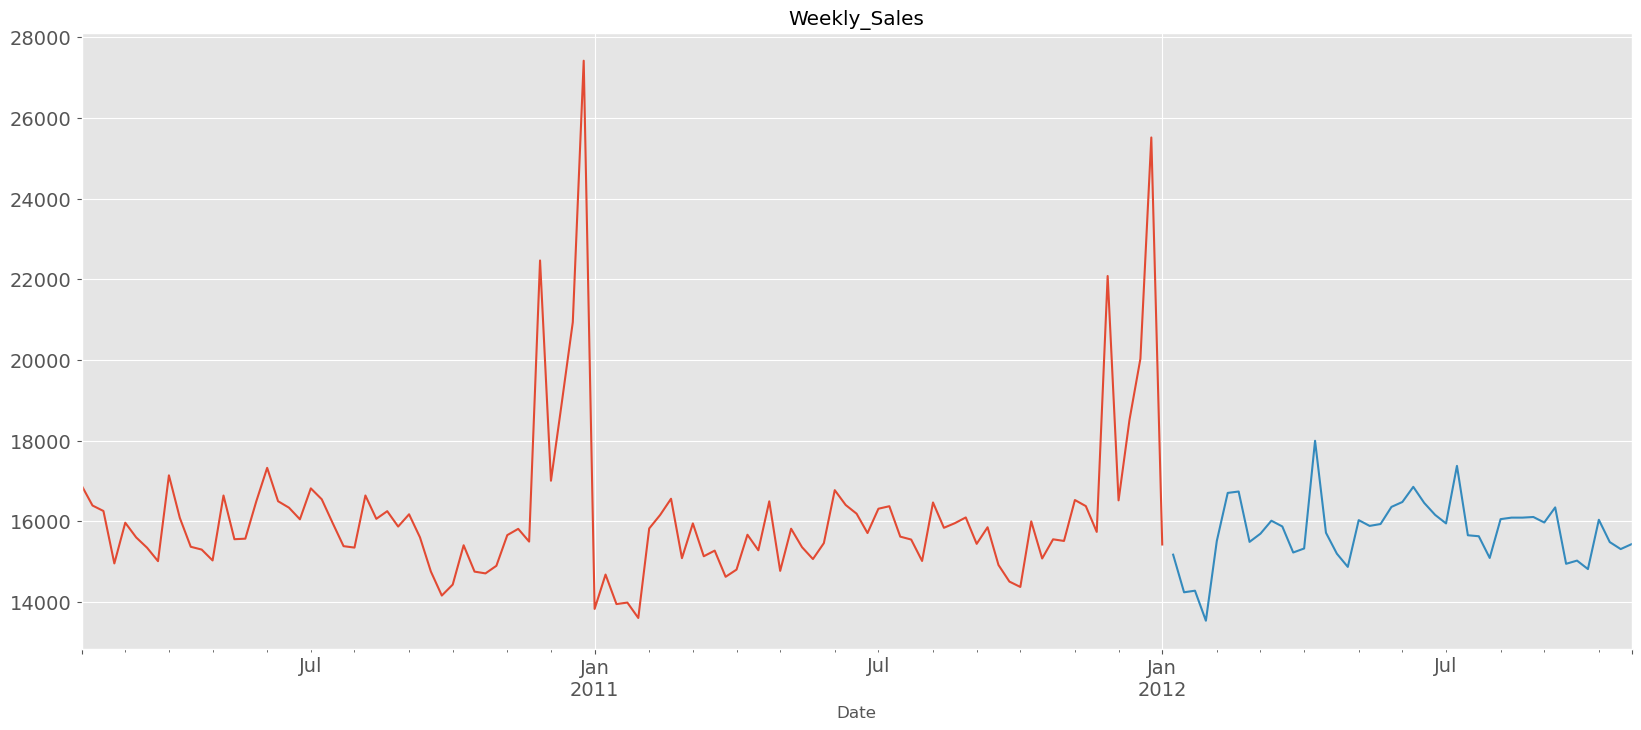

In [128]:
train_data['Weekly_Sales'].plot(figsize=(20,8), title= 'Weekly_Sales', fontsize=14)
test_data['Weekly_Sales'].plot(figsize=(20,8), title= 'Weekly_Sales', fontsize=14)
plt.show()

Blue line represents my train data, yellow is test data.

# Decomposing Weekly Data to Observe Seasonality

In [129]:
decomposed = decompose(df_week['Weekly_Sales'].values, 'additive', m=20) #decomposing of weekly data 

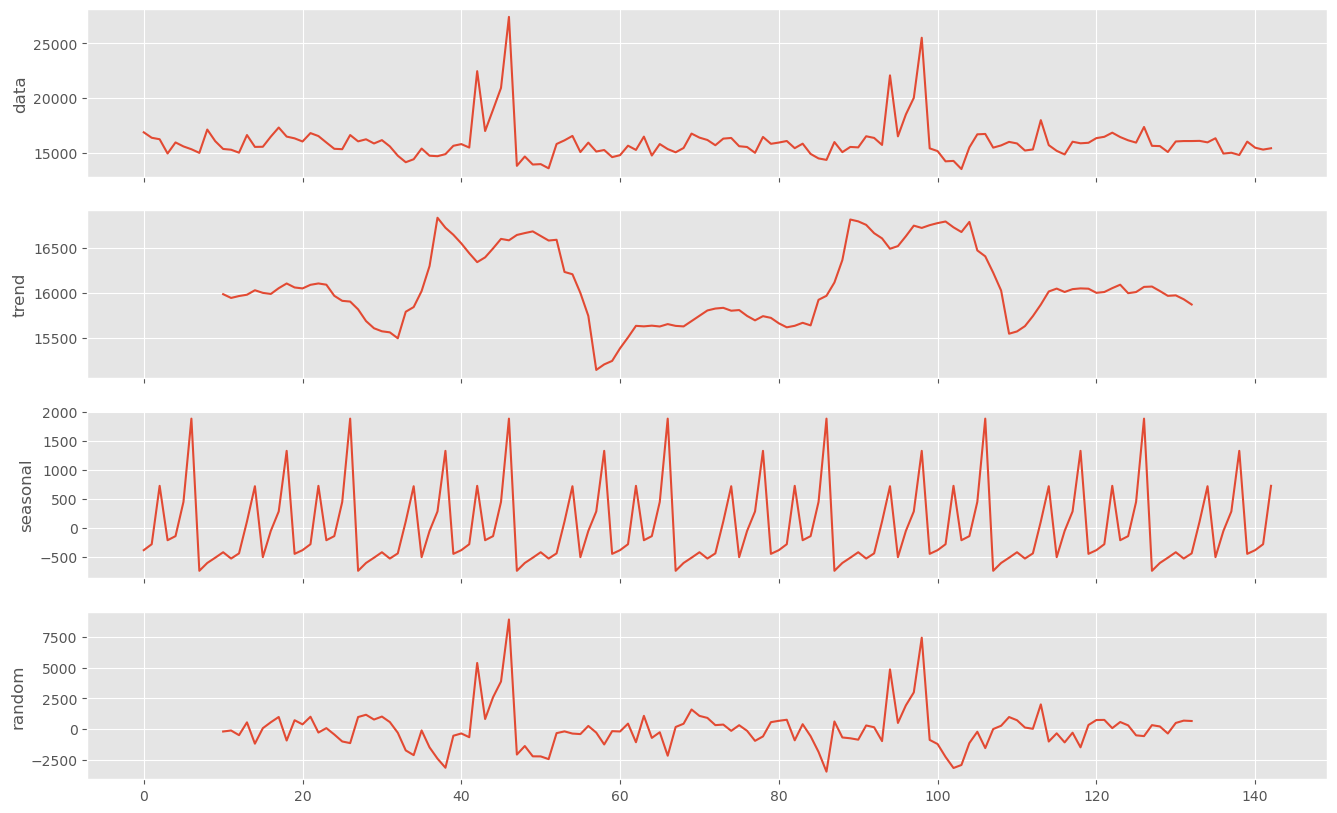

In [130]:
decomposed_plot(decomposed, figure_kwargs={'figsize': (16, 10)})
plt.show()

From the graphs above, every 20 step seasonality converges to beginning point. This helps me to tune my model.

# Trying To Make Data More Stationary

Now, I will try to make my data more stationary. To do this, I will try model with differenced, logged and shifted data.

## 1. Difference

In [131]:
df_week_diff = df_week['Weekly_Sales'].diff().dropna() #creating difference values

In [132]:
# taking mean and std of differenced data
diff_roll_mean = df_week_diff.rolling(window=2, center=False).mean()
diff_roll_std = df_week_diff.rolling(window=2, center=False).std()

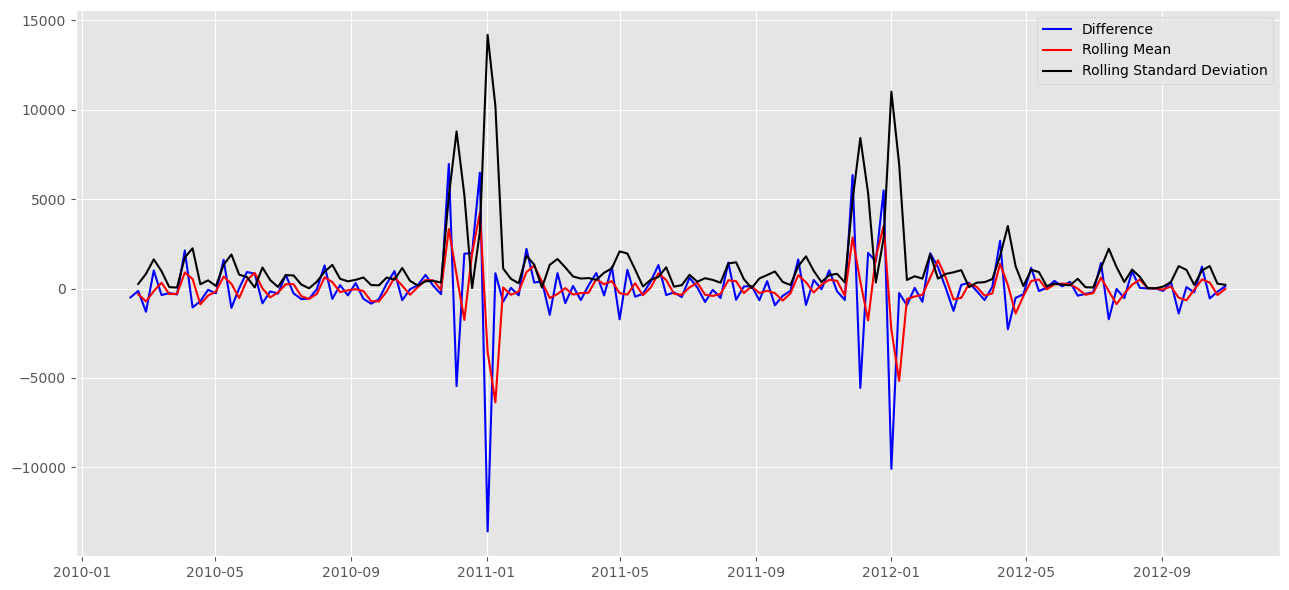

In [133]:
fig, ax = plt.subplots(figsize=(13, 6))
ax.plot(df_week_diff, color='blue',label='Difference')
ax.plot(diff_roll_mean, color='red', label='Rolling Mean')
ax.plot(diff_roll_std, color='black', label='Rolling Standard Deviation')
ax.legend()
fig.tight_layout()

## 2.Shift

In [134]:
df_week_lag = df_week['Weekly_Sales'].shift().dropna() #shifting the data 

In [135]:
lag_roll_mean = df_week_lag.rolling(window=2, center=False).mean() 
lag_roll_std = df_week_lag.rolling(window=2, center=False).std()

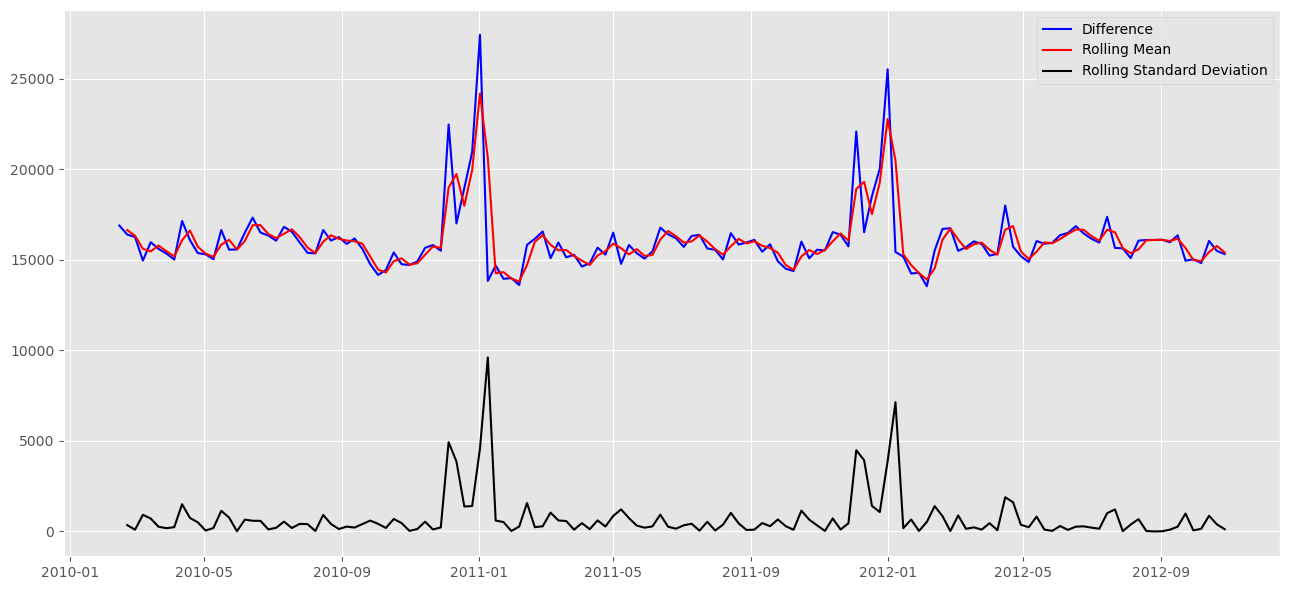

In [136]:
fig, ax = plt.subplots(figsize=(13, 6))
ax.plot(df_week_lag, color='blue',label='Difference')
ax.plot(lag_roll_mean, color='red', label='Rolling Mean')
ax.plot(lag_roll_std, color='black', label='Rolling Standard Deviation')
ax.legend()
fig.tight_layout()

## 3.Log

In [137]:
logged_week = np.log1p(df_week['Weekly_Sales']).dropna() #taking log of data

In [138]:
log_roll_mean = logged_week.rolling(window=2, center=False).mean()
log_roll_std = logged_week.rolling(window=2, center=False).std()

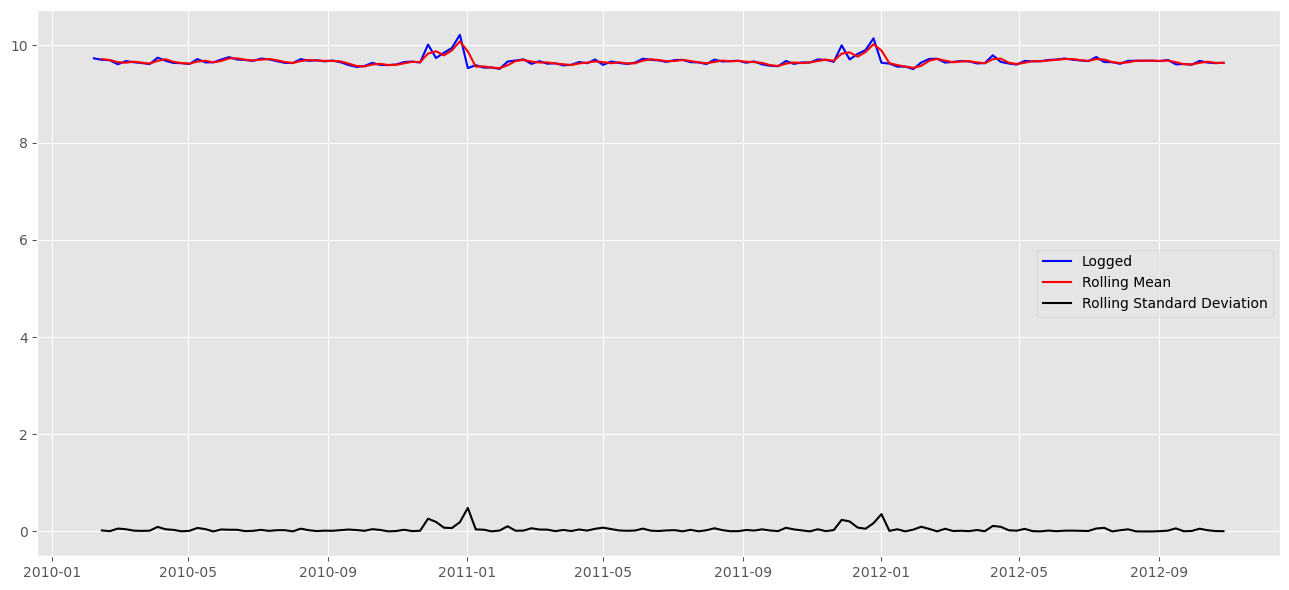

In [139]:
fig, ax = plt.subplots(figsize=(13, 6))
ax.plot(logged_week, color='blue',label='Logged')
ax.plot(log_roll_mean, color='red', label='Rolling Mean')
ax.plot(log_roll_std, color='black', label='Rolling Standard Deviation')
ax.legend()
fig.tight_layout()

# Auto-ARIMA MODEL

I tried my data without any changes, then tried with shifting, taking log and difference version of data. Differenced data gave best results. So, I decided to take difference and use this data. 

# Train-Test Split

In [140]:
train_data_diff = df_week_diff [:int(0.7*(len(df_week_diff )))]
test_data_diff = df_week_diff [int(0.7*(len(df_week_diff ))):]

In [141]:
# train_data = train_data['Weekly_Sales']
# test_data = test_data['Weekly_Sales']

model_auto_arima = auto_arima(train_data_diff, trace=True,start_p=0, start_q=0, start_P=0, start_Q=0,
                  max_p=20, max_q=20, max_P=20, max_Q=20, seasonal=True,maxiter=200,
                  information_criterion='aic',stepwise=False, suppress_warnings=True, D=1, max_D=10,
                  error_action='ignore',approximation = False)
model_auto_arima.fit(train_data_diff)

 ARIMA(0,0,0)(0,0,0)[1] intercept   : AIC=1826.858, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[1] intercept   : AIC=1793.619, Time=0.02 sec
 ARIMA(0,0,2)(0,0,0)[1] intercept   : AIC=1795.532, Time=0.04 sec
 ARIMA(0,0,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(0,0,4)(0,0,0)[1] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,0,5)(0,0,0)[1] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(1,0,0)(0,0,0)[1] intercept   : AIC=1804.051, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[1] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(1,0,2)(0,0,0)[1] intercept   : AIC=1794.966, Time=0.05 sec
 ARIMA(1,0,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(1,0,4)(0,0,0)[1] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(2,0,0)(0,0,0)[1] intercept   : AIC=1801.215, Time=0.01 sec
 ARIMA(2,0,1)(0,0,0)[1] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(2,0,2)(0,0,0)[1] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(2,0,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(3,0,0)(0,0,0)[1] intercept   : AIC=1791.045, Tim

ARIMA(maxiter=200, order=(3, 0, 2), scoring_args={},
      seasonal_order=(0, 0, 0, 1), suppress_warnings=True)

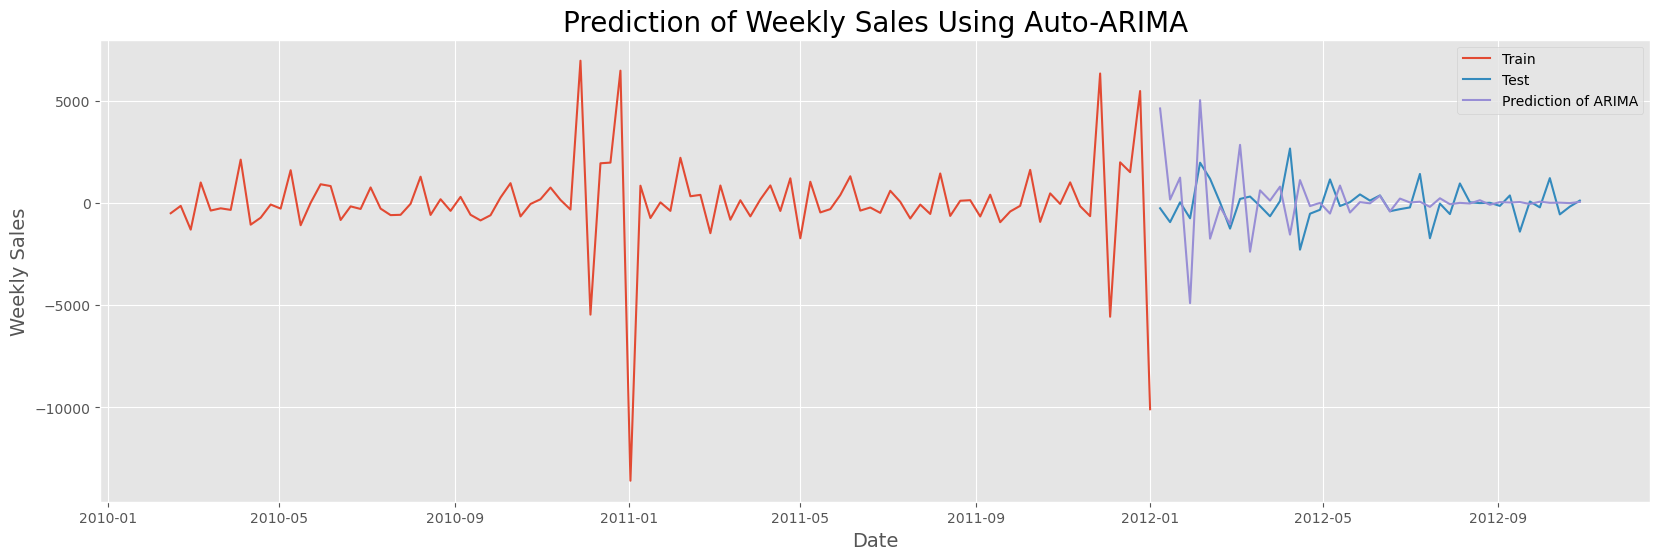

In [142]:
y_pred = model_auto_arima.predict(n_periods=len(test_data_diff))
y_pred = pd.DataFrame(y_pred,index = test_data.index,columns=['Prediction'])
plt.figure(figsize=(20,6))
plt.title('Prediction of Weekly Sales Using Auto-ARIMA', fontsize=20)
plt.plot(train_data_diff, label='Train')
plt.plot(test_data_diff, label='Test')
plt.plot(y_pred, label='Prediction of ARIMA')
plt.legend(loc='best')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Weekly Sales', fontsize=14)
plt.show()

I do not like the pattern of predictions so I decided to try another model.

# ExponentialSmoothing

I checked suitable Holt-Winters models according tp my data. Exponential Smooting are used when data has trend, and it flattens the trend. The damped trend method adds a damping parameter so, the trend converges to a constant value in the future. 

My difference data has some minus and zero values, so I used additive seasonal and trend instead of multiplicative. Seasonal periods are chosen from the decomposed graphs above. For tuning the model with iterations take too much time so, I changed and tried model for different parameters and found the best parameters and fitted them to model.

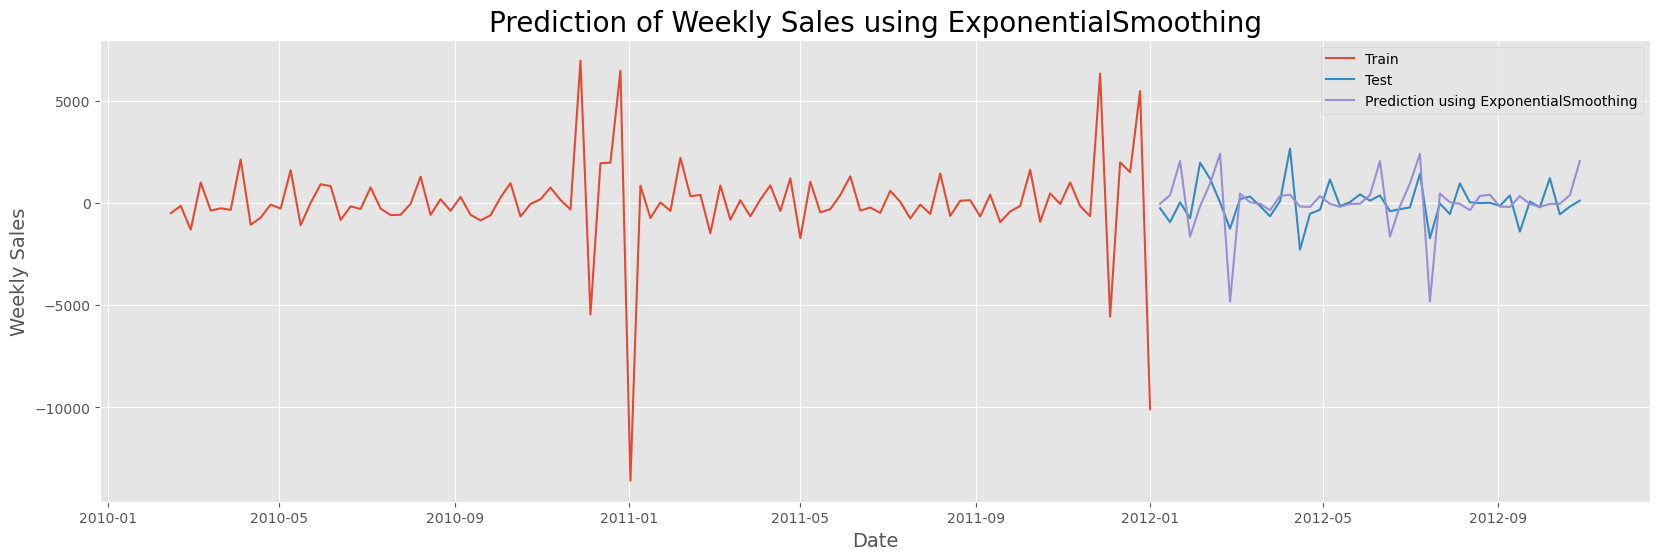

In [143]:
model_holt_winters = ExponentialSmoothing(train_data_diff, seasonal_periods=20, seasonal='additive',
                                           trend='additive',damped=True).fit() #Taking additive trend and seasonality.
y_pred = model_holt_winters.forecast(len(test_data_diff))# Predict the test data

#Visualize train, test and predicted data.
plt.figure(figsize=(20,6))
plt.title('Prediction of Weekly Sales using ExponentialSmoothing', fontsize=20)
plt.plot(train_data_diff, label='Train')
plt.plot(test_data_diff, label='Test')
plt.plot(y_pred, label='Prediction using ExponentialSmoothing')
plt.legend(loc='best')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Weekly Sales', fontsize=14)
plt.show()


In [144]:
wmae_test(test_data_diff, y_pred)
y_pred

KeyError: 'IsHoliday'

At the end, I found best results for my data with Exponential Smoothing Model.

My best result for this project is 821. According to sales amounts this value is roughly around 4-5% error. If we can take our average sales and take percentage of 821 errors, it gives 4-5% roughly. 